# *REPLY: ANOMALY DETECTION* 

### Flavia Fuscaldi, Giacomo Guerra, Caterina Perrotti

#### import the necessary libraries, here the version used: 

In [445]:
import random
import numpy as np
import torch
import os
import tensorflow as tf

SEED = 28
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(SEED)
tf.random.set_seed(SEED)

In [446]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

from sklearn.ensemble import IsolationForest, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    LSTM, Dense, Dropout, BatchNormalization,
    Input, RepeatVector, TimeDistributed
)
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics.pairwise import cosine_similarity

from prophet import Prophet


### EDA

load the dataset assigning as header the first row

In [447]:
df = pd.read_excel("FullDayWithAlarms.xlsx", header=1)  # Use the second row as the header
df.sort_values(by='DATA ORA', inplace=True)

rename the columns to be easier to recall later in the notebok and convert `Timestamp` in date type

In [448]:
df.columns

Index(['COD \nGIOCO', 'DATA ORA', 'INTERVALLO\nACQUISIZIONE',
       'NUMERO\nTRANSAZIONI', 'TEMPO MIN', 'TEMPO MAX', 'TEMPO MEDIO',
       'NUMERO RETRY', 'NUMERO \nTRANSAZIONI ERRATE'],
      dtype='object')

In [449]:
df = df.rename(columns={
    'COD \nGIOCO': 'Code_ID',
    'DATA ORA': 'Timestamp',
    'NUMERO\nTRANSAZIONI': 'Number_of_Transactions',
    'TEMPO MIN': 'Time_Min',
    'TEMPO MAX': 'Time_Max',
    'TEMPO MEDIO': 'Time_Avg',
    'NUMERO RETRY': 'Number_of_Retries',
    'NUMERO \nTRANSAZIONI ERRATE': 'Number_of_Wrong_Transactions'
})

df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

In [450]:
df.columns

Index(['Code_ID', 'Timestamp', 'INTERVALLO\nACQUISIZIONE',
       'Number_of_Transactions', 'Time_Min', 'Time_Max', 'Time_Avg',
       'Number_of_Retries', 'Number_of_Wrong_Transactions'],
      dtype='object')

check for missing values

In [451]:
print(df['Timestamp'].isna().sum())

0


drop features irrelevant for our analysis: `INTERVALLO\nACQUISIZIONE` and `Code_ID`

In [452]:
df.drop(columns=['INTERVALLO\nACQUISIZIONE'], inplace=True)
df.drop(columns=['Code_ID'], inplace=True)

df

,Timestamp,Number_of_Transactions,Time_Min,Time_Max,Time_Avg,Number_of_Retries,Number_of_Wrong_Transactions
0,2024-05-31 07:01:11,366,6,1019,25.907562,0,90
1,2024-05-31 07:02:11,948,7,90,18.181719,0,90
2,2024-05-31 07:03:11,1273,7,408,18.813356,0,90
3,2024-05-31 07:04:11,1538,6,70,16.607435,0,90
4,2024-05-31 07:05:11,703,5,85,16.645409,0,90
...,...,...,...,...,...,...,...
1013,2024-05-31 23:55:23,1061,3,83,10.171293,0,167
1014,2024-05-31 23:56:23,974,3,53,10.172589,0,185
1015,2024-05-31 23:57:23,995,4,55,9.933611,0,141
1016,2024-05-31 23:58:23,936,3,39,10.171029,0,196


display info and summary statistics about the dataframe obtained

In [453]:
df.shape

(1018, 7)

In [454]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1018 entries, 0 to 1017
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Timestamp                     1018 non-null   datetime64[ns]
 1   Number_of_Transactions        1018 non-null   int64         
 2   Time_Min                      1018 non-null   int64         
 3   Time_Max                      1018 non-null   int64         
 4   Time_Avg                      1018 non-null   float64       
 5   Number_of_Retries             1018 non-null   int64         
 6   Number_of_Wrong_Transactions  1018 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(5)
memory usage: 63.6 KB


In [455]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Number_of_Transactions,1018.0,2245.859528,1136.991871,204.000000,1424.750000,2323.00000,3007.000000,5057.0000
Time_Min,1018.0,2.737721,0.934939,0.000000,3.000000,3.00000,3.000000,7.0000
Time_Max,1018.0,1346.666994,7207.947520,28.000000,82.000000,124.00000,232.500000,92682.0000
Time_Avg,1018.0,49.715493,182.782991,9.462604,11.039727,12.34944,13.582763,2019.2717
Number_of_Retries,1018.0,89.292731,599.256239,0.000000,0.000000,0.00000,0.000000,6496.0000
Number_of_Wrong_Transactions,1018.0,155.943026,47.440950,81.000000,122.250000,149.00000,186.000000,448.0000


see the correlation among the features in the dataframe

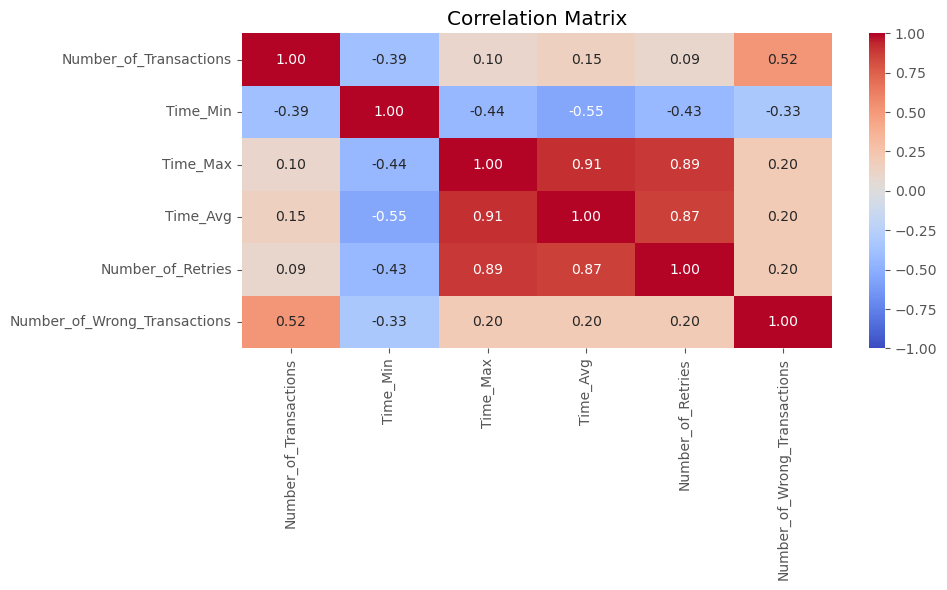

In [456]:
numeric = df.drop(columns=['Timestamp'])

correlation_matrix = numeric.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

plot the distribution of the numerical features over time to detect patterns and outliers

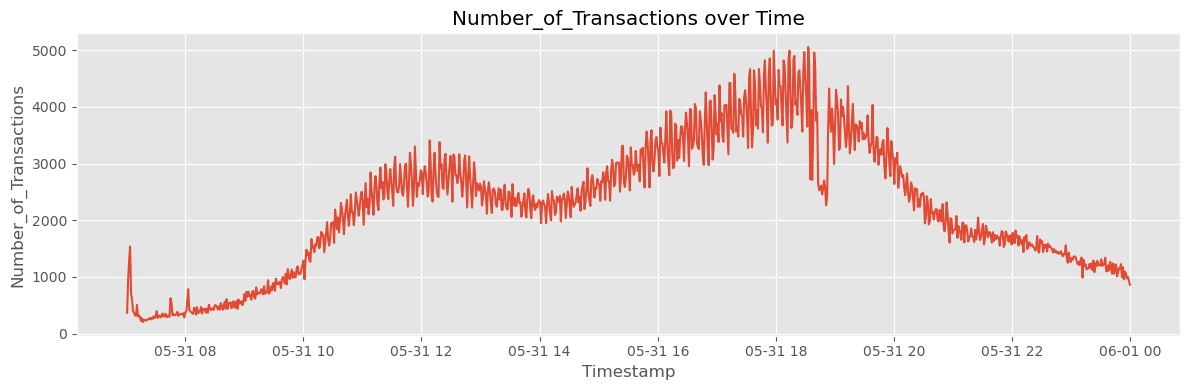

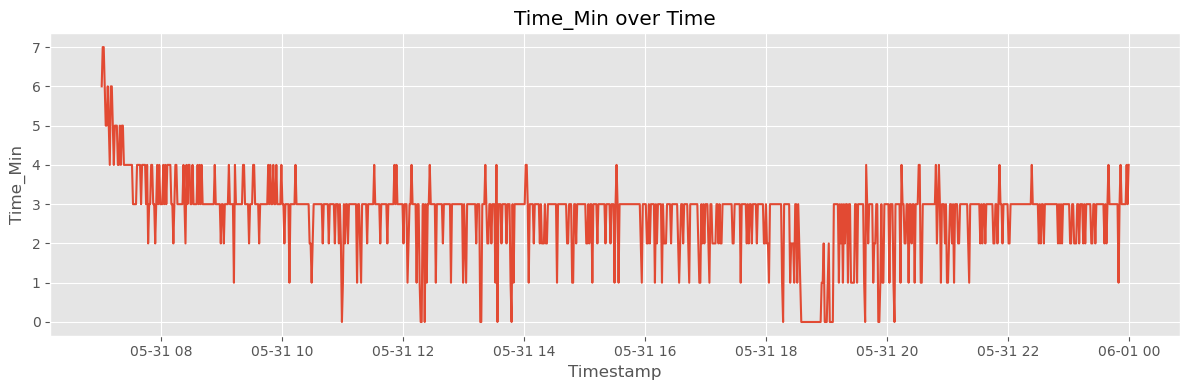

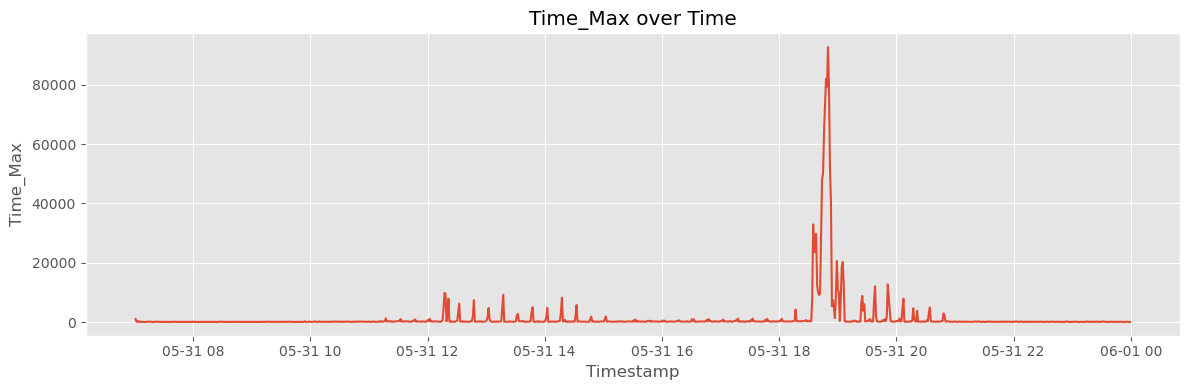

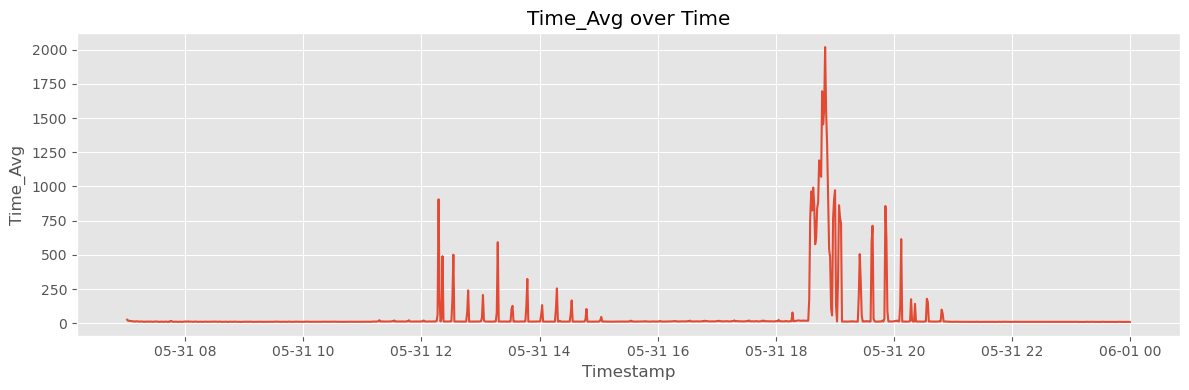

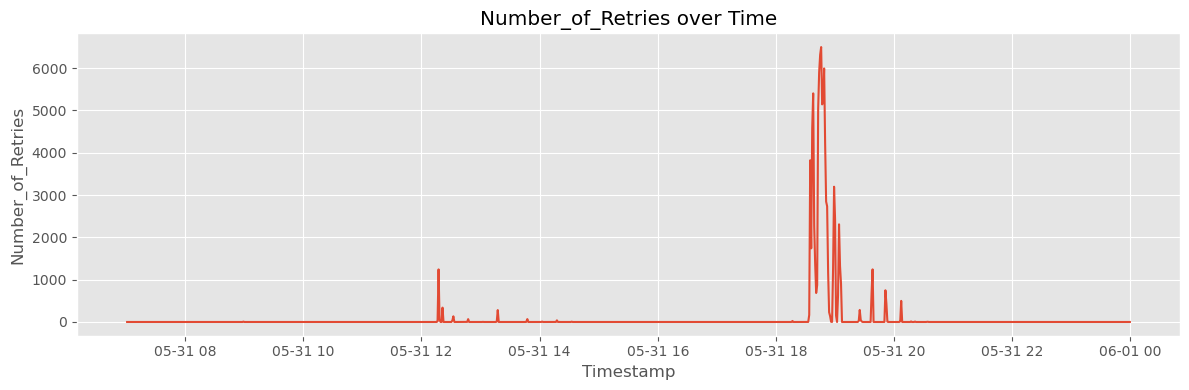

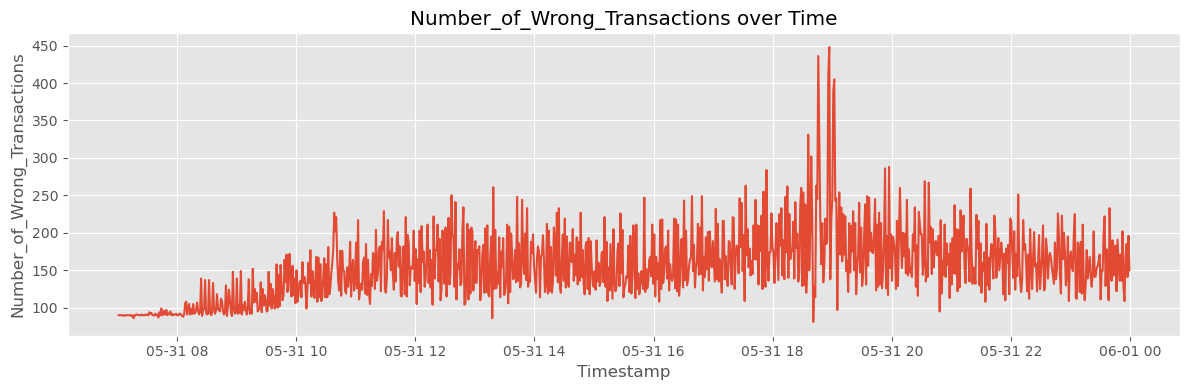

In [457]:
plt.style.use('ggplot')

columns_to_plot = [
    'Number_of_Transactions', 'Time_Min', 'Time_Max',
    'Time_Avg', 'Number_of_Retries', 'Number_of_Wrong_Transactions']

for col in columns_to_plot:
    plt.figure(figsize=(12, 4))
    plt.plot(df['Timestamp'], df[col])
    plt.title(f'{col} over Time')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

- from the plots we can see the precence of outliers around 7 pm
- if the goal is to build a forecasting model able to give as output the expected trend of the series, we thought was necessary to eliminate these clear outliers in order to make the model able to learn the right pattern, avoiding it being biased by outliers of that specific day
- we used an isolation forest to flag the outliers and remove them for training multivariate approach
- we considered for our analysis the following features: `Number_of_Transactions`, `Time_Avg`, `Number_of_Wrong_Transactions`, `Number_of_Retries`

In [458]:
features = ['Number_of_Transactions', 'Time_Avg', 'Number_of_Wrong_Transactions', 'Number_of_Retries']
X = df[features]

iso_forest = IsolationForest(contamination=0.035, random_state=42)
df['outlier'] = iso_forest.fit_predict(X)
df['is_outlier'] = df['outlier'] == -1

outlier_sum = df['is_outlier'].sum()
outlier_sum

36

plot the outliers detected

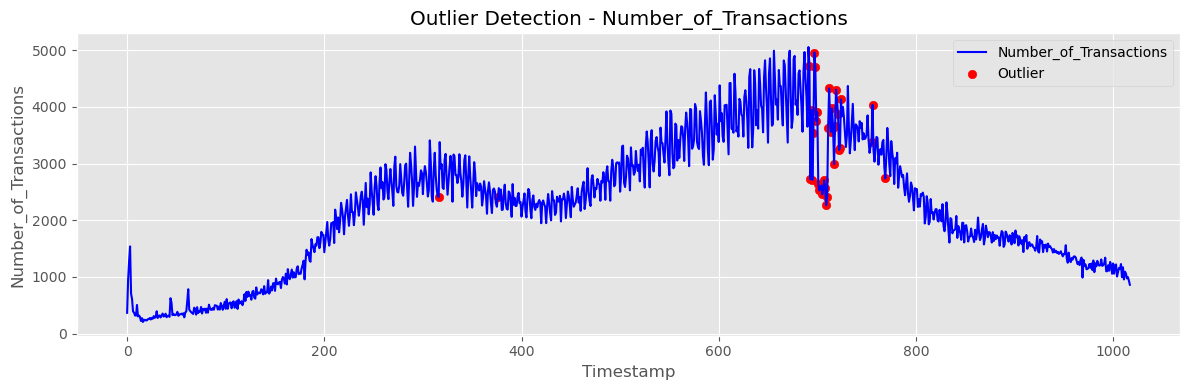

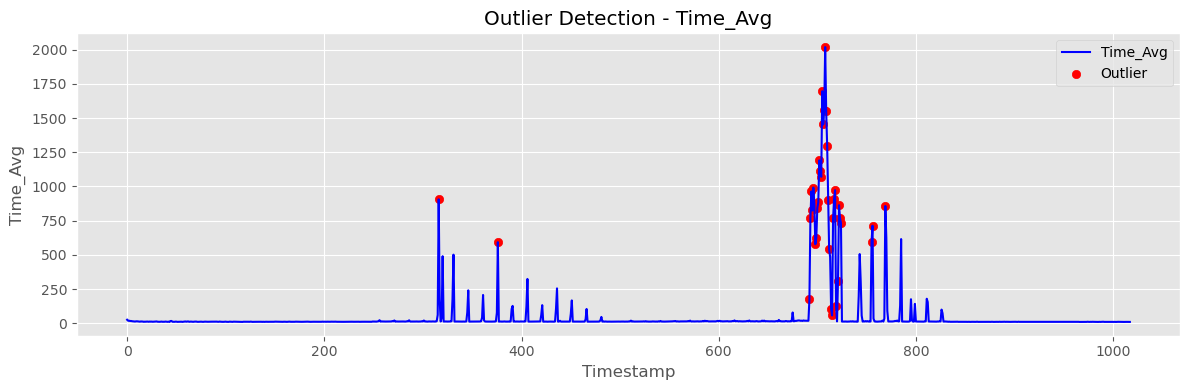

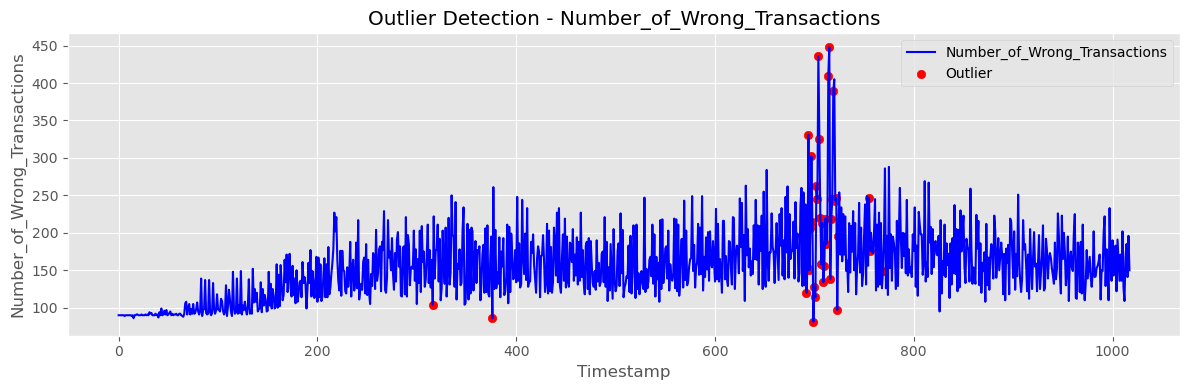

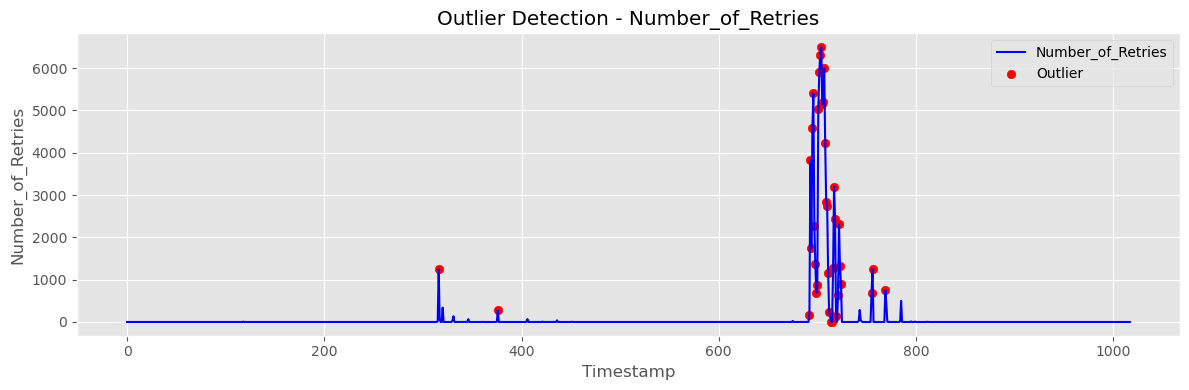

In [459]:
for feature in features:
    plt.figure(figsize=(12, 4))
    plt.plot(df.index, df[feature], label=feature, color='blue')
    plt.scatter(
        df[df['is_outlier']].index,
        df[df['is_outlier']][feature],
        color='red',
        label='Outlier',
        marker='o'
    )
    plt.title(f'Outlier Detection - {feature}')
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

df without outliers, they are replaced with NaN

In [460]:
df_cleaned = df.copy()
for col in features:
    df_cleaned.loc[df_cleaned['is_outlier'], col] = np.nan
df_cleaned

,Timestamp,Number_of_Transactions,Time_Min,Time_Max,Time_Avg,Number_of_Retries,Number_of_Wrong_Transactions,outlier,is_outlier
0,2024-05-31 07:01:11,366.0,6,1019,25.907562,0.0,90.0,1,False
1,2024-05-31 07:02:11,948.0,7,90,18.181719,0.0,90.0,1,False
2,2024-05-31 07:03:11,1273.0,7,408,18.813356,0.0,90.0,1,False
3,2024-05-31 07:04:11,1538.0,6,70,16.607435,0.0,90.0,1,False
4,2024-05-31 07:05:11,703.0,5,85,16.645409,0.0,90.0,1,False
...,...,...,...,...,...,...,...,...,...
1013,2024-05-31 23:55:23,1061.0,3,83,10.171293,0.0,167.0,1,False
1014,2024-05-31 23:56:23,974.0,3,53,10.172589,0.0,185.0,1,False
1015,2024-05-31 23:57:23,995.0,4,55,9.933611,0.0,141.0,1,False
1016,2024-05-31 23:58:23,936.0,3,39,10.171029,0.0,196.0,1,False


replace NaN values using:

- 1-hour rolling mean and standard deviation  
- Random noise (normal distribution)  
- Min/max clipping to stay within realistic bounds  

each feature in the `features` list is handled based on its type, with optional constraints to avoid unrealistic values. The goal is to preserve temporal consistency while generating plausible replacements for missing data.


In [461]:
df_cleaned = df_cleaned.sort_values("Timestamp").copy()
df_cleaned.set_index("Timestamp", inplace=True)

min_time_avg = df_cleaned["Time_Avg"].min(skipna=True)
min_retries = df_cleaned["Number_of_Retries"].min(skipna=True)
min_wrong_transactions = df_cleaned["Number_of_Wrong_Transactions"].min(skipna=True)
max_wrong_transactions = df_cleaned["Number_of_Wrong_Transactions"].max(skipna=True)
max_transactions = df_cleaned["Number_of_Transactions"].max(skipna=True)


for col in features:
    mean = df_cleaned[col].rolling("1H", min_periods=1).mean()
    std = df_cleaned[col].rolling("1H", min_periods=1).std()
    
    missing = df_cleaned[col].isna()
    noise = np.random.normal(0, 1, size=missing.sum())

    values = mean[missing] + noise * std[missing] * 0.5

    
    if col == "Time_Avg":
        values = values.clip(lower=min_time_avg)
    elif col == "Number_of_Retries":
        values = values.clip(lower=min_retries)
    elif col == "Number_of_Wrong_Transactions":
        values = values.clip(lower=min_wrong_transactions, upper=max_wrong_transactions)
    elif col == "Number_of_Transactions":
        values = values.clip(upper=max_transactions)
   

    
    df_cleaned.loc[missing, col] = values.round().astype(int)


df_cleaned.reset_index(inplace=True)


plot the new distribution with the imputation of NaN due to outliers removal

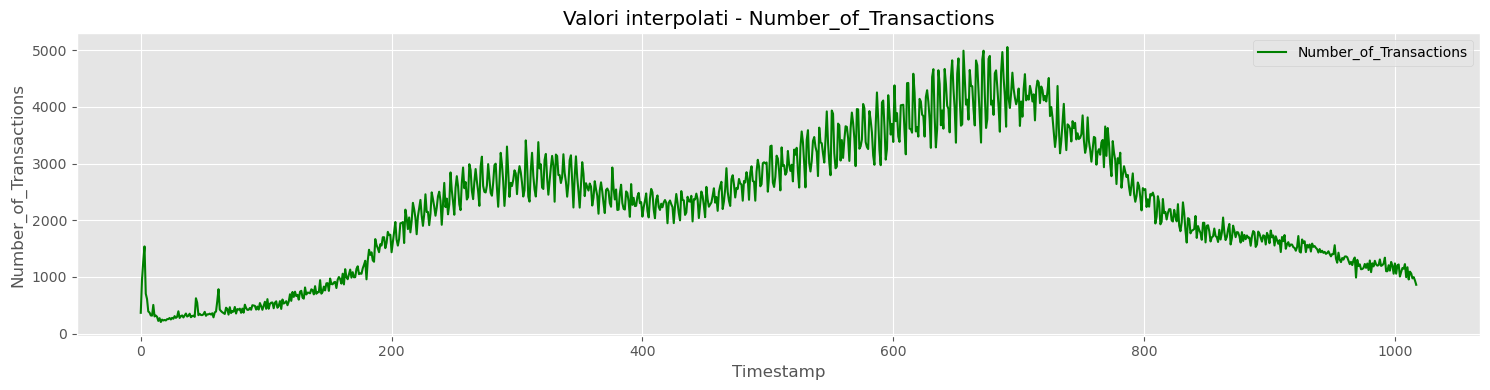

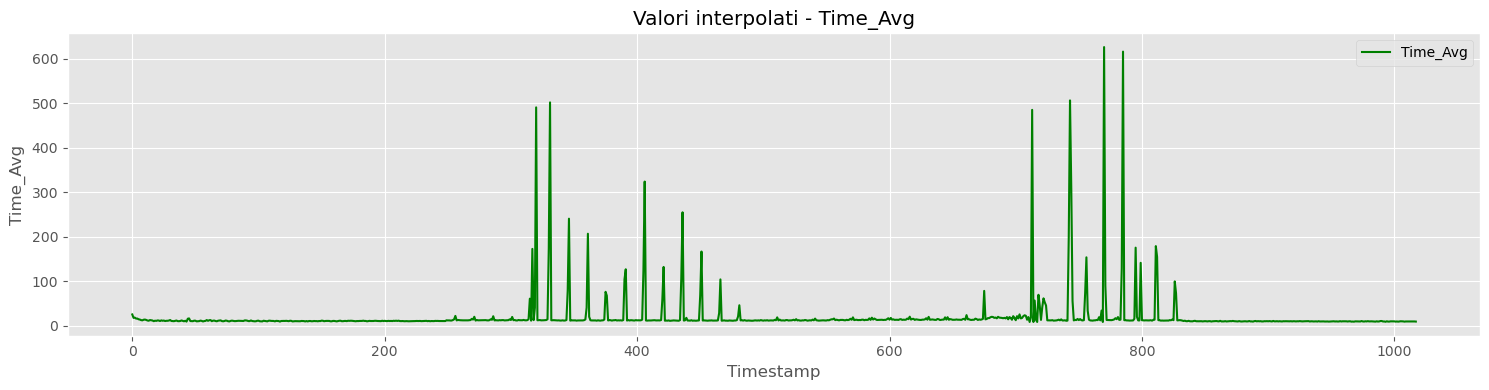

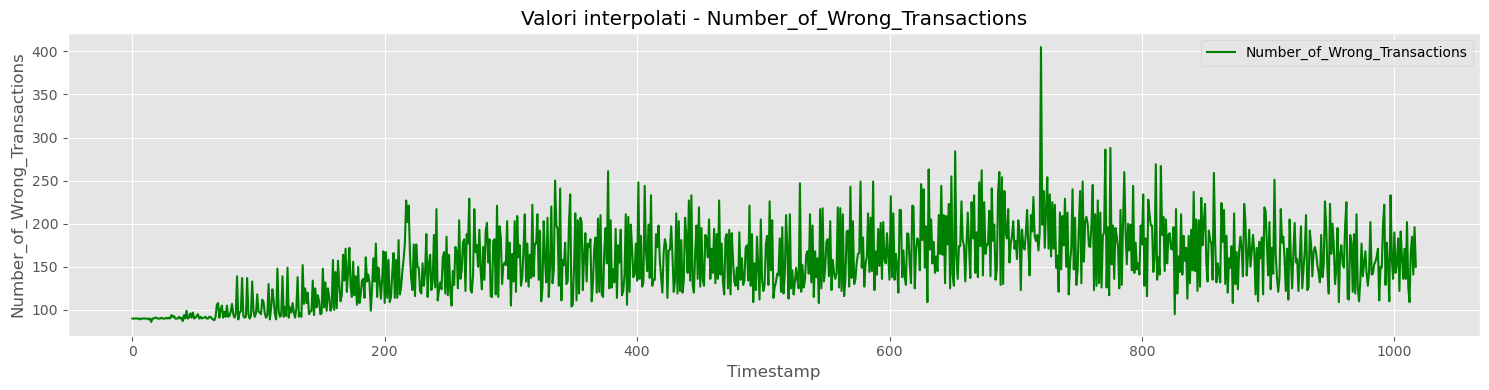

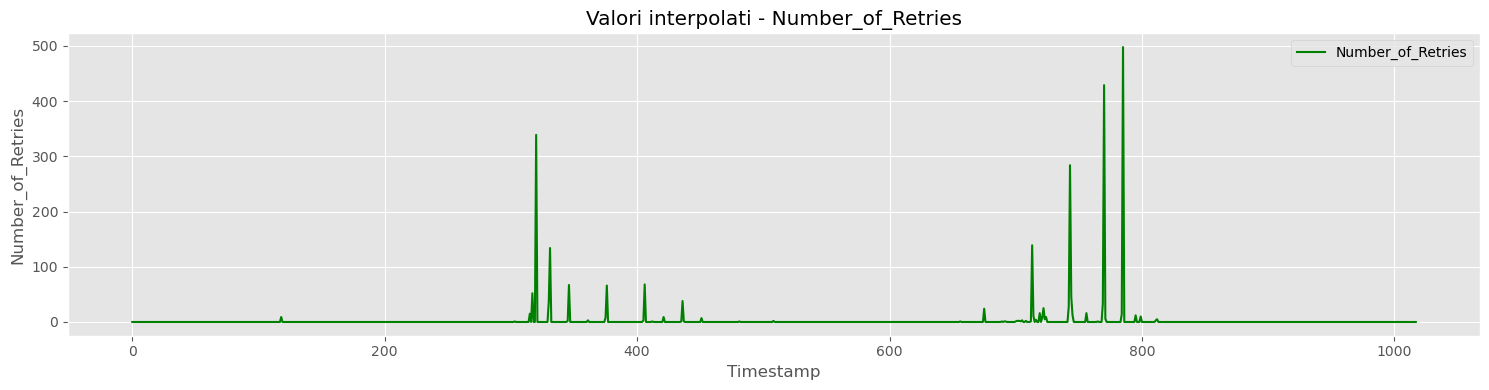

In [462]:
for feature in features:
    plt.figure(figsize=(15, 4))
    plt.plot(df_cleaned.index, df_cleaned[feature], label=feature, color='green')
    plt.title(f'Valori interpolati - {feature}')
    plt.xlabel('Timestamp')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [463]:
df_cleaned.isna().sum()

Timestamp                       0
Number_of_Transactions          0
Time_Min                        0
Time_Max                        0
Time_Avg                        0
Number_of_Retries               0
Number_of_Wrong_Transactions    0
outlier                         0
is_outlier                      0
dtype: int64

clean the dataset removing features irrelevant for the anlysis and rename the clean dataset as *day 1*

In [464]:
df_cleaned = df_cleaned.drop(columns=['Time_Min', 'Time_Max', 'outlier', 'is_outlier'])

In [465]:
day1 = df_cleaned.copy()

### SYNTHETIC DATA AUGMENTATION

creation of a function to add more days to the dataframe based on the injection of some noise. 
NB As explained in the Readme, we have tried to use more advanced techniques for data augmentation:
- GAN/TimeGAN
- VAE 

however, the results obtained were not satisfactory, so we opted for a statistical approach in data augmentation.

In [466]:
def new_jittered_day(df_originale, data_nuova="2024-06-01", jitter_range=(0.01, 0.05), random_state=None, day_label="DayX"):
  
    if random_state is not None:
        np.random.seed(random_state)

    synthetic = df_originale.copy()
    numeric_columns = synthetic.select_dtypes(include=[np.number]).columns

    for col in numeric_columns:
        scale_factor = np.random.uniform(*jitter_range)
        std_dev = df_originale[col].std()
        noise = np.random.normal(loc=0, scale=scale_factor * std_dev, size=synthetic.shape[0])

        synthetic[col] = synthetic[col] + noise
        synthetic[col] = synthetic[col].clip(lower=0)
        synthetic[col] = synthetic[col].round().astype(int)

    old_timestamps = pd.to_datetime(df_originale['Timestamp'])
    delta_times = (old_timestamps - old_timestamps.iloc[0])
    new_start = pd.to_datetime(f"{data_nuova} 07:01:00")
    synthetic['Timestamp'] = new_start + delta_times

    # Aggiungi colonna di identificazione giorno
    synthetic['Day'] = day_label

    return synthetic

we use the function to add two more days to the dataset

In [467]:
day2 = new_jittered_day(day1, data_nuova="2024-06-01", random_state=42, day_label="Day2")
day3 = new_jittered_day(day1, data_nuova="2024-06-02", random_state=123, day_label="Day3")

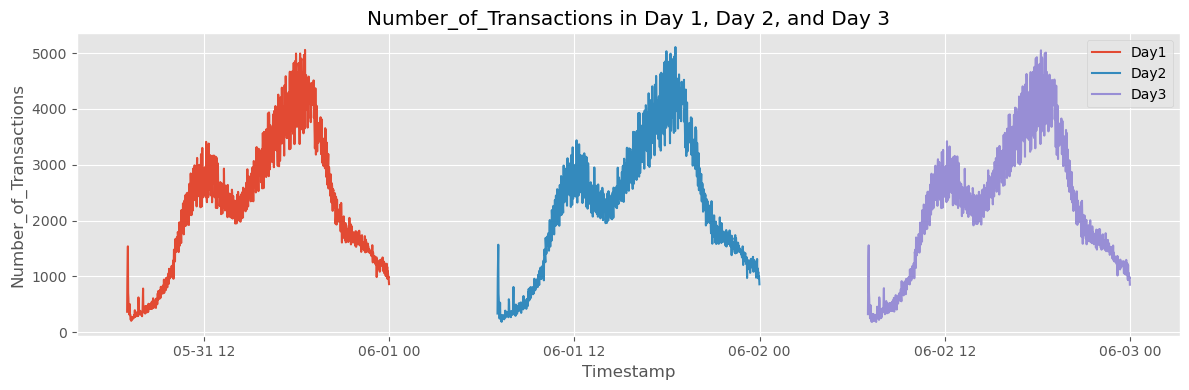

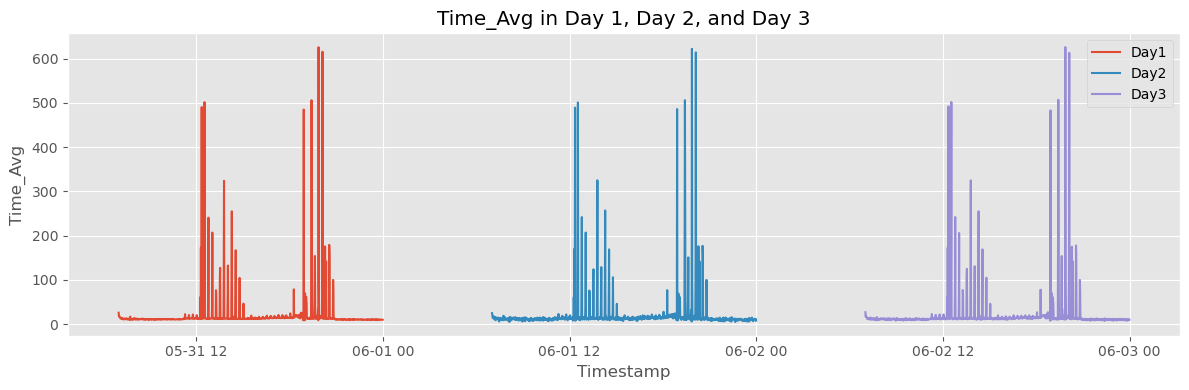

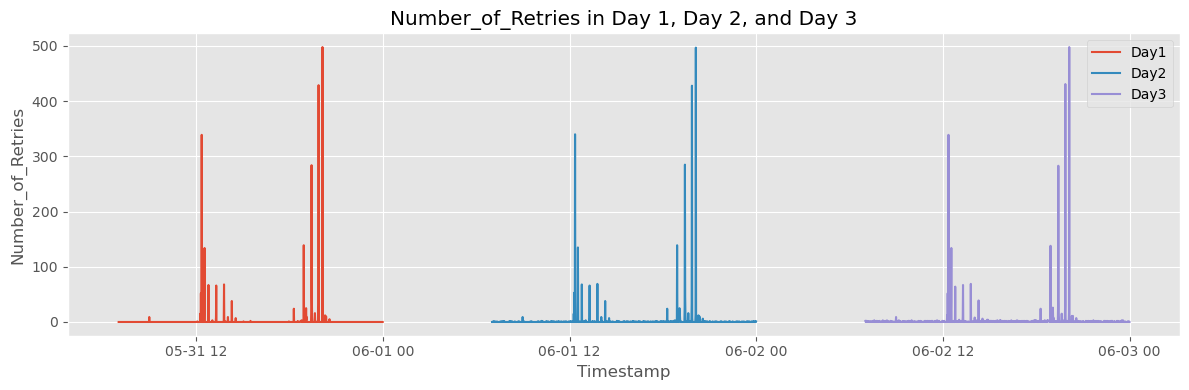

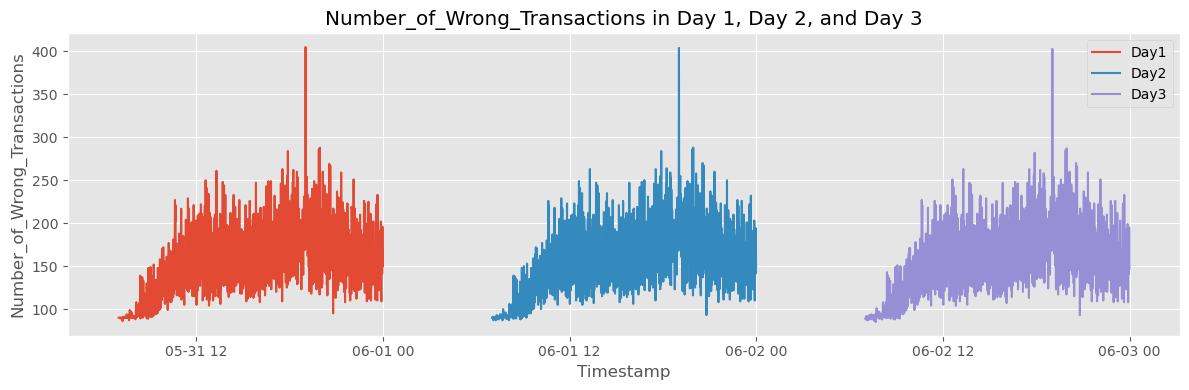

In [468]:
day1['Day'] = 'Day1'
day2['Day'] = 'Day2'
day3['Day'] = 'Day3'


df_complete = pd.concat([day1, day2, day3])
df_complete['Timestamp'] = pd.to_datetime(df_complete['Timestamp'])

variables = ['Number_of_Transactions', 'Time_Avg', 'Number_of_Retries', 'Number_of_Wrong_Transactions']

for var in variables:
    plt.figure(figsize=(12, 4))
    for day, subset in df_complete.groupby('Day'):
        plt.plot(subset['Timestamp'], subset[var], label=day)
    plt.title(f'{var} in Day 1, Day 2, and Day 3')
    plt.xlabel('Timestamp')
    plt.ylabel(var)
    plt.legend()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

see statistical distribution of the three days' features

Summary Statistics for Number of Transactions by Day:


,count,mean,std,min,25%,50%,75%,max
Day,,,,,,,,
Day1,1018.0,2272.942043,1164.630204,204.0,1424.75,2326.5,3066.75,5057.0
Day2,1018.0,2273.730845,1164.097984,186.0,1415.00,2325.0,3077.25,5108.0
Day3,1018.0,2270.417485,1164.506160,183.0,1426.00,2324.0,3065.25,5050.0


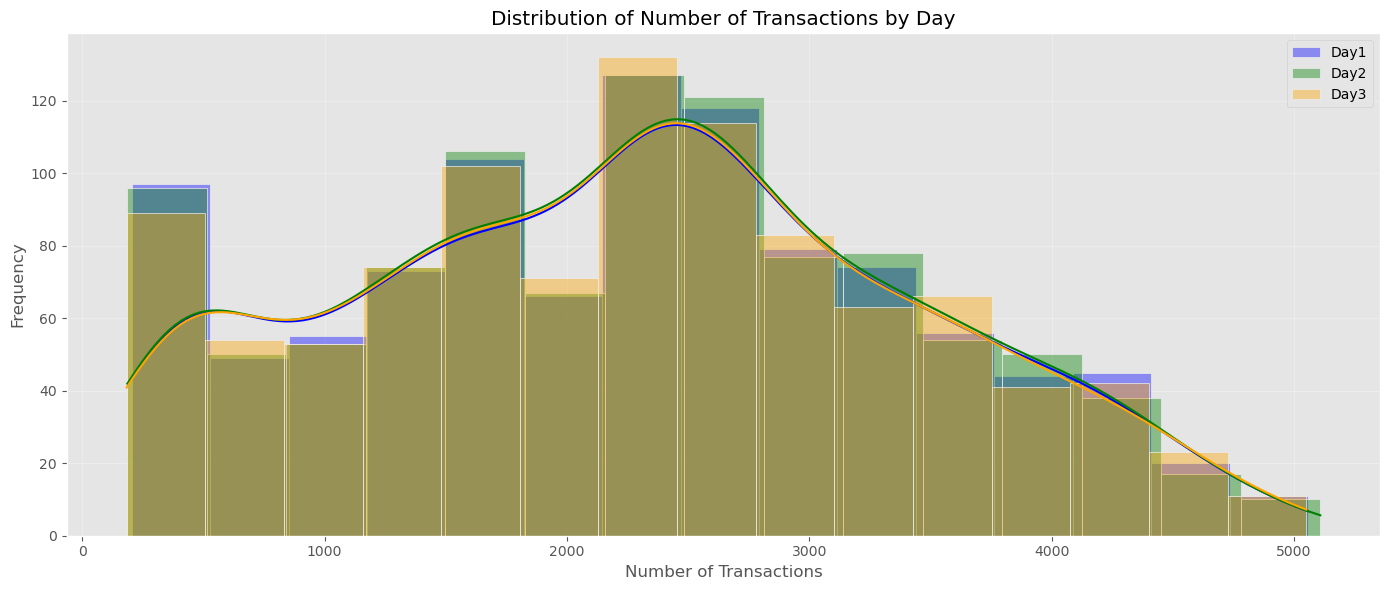

In [469]:
day_stats = df_complete.groupby('Day')['Number_of_Transactions'].describe()
print("Summary Statistics for Number of Transactions by Day:")
display(day_stats)

plt.figure(figsize=(14, 6))
for day, color in zip(['Day1', 'Day2', 'Day3'], ['blue', 'green', 'orange']):
    sns.histplot(df_complete[df_complete['Day'] == day]['Number_of_Transactions'], 
                 label=day, color=color, kde=True, alpha=0.4)
plt.title('Distribution of Number of Transactions by Day')
plt.xlabel('Number of Transactions')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### FEATURE ENGINEERING

definition of a function that creates daily meaningful features that help capture patterns, trends, and temporal behavior. it adds:

- Lagged values 
- Rolling statistics
- Changes between time steps 
- Ratios for errors and retries
- time of day 

these features are useful for training machine learning models on temporal data, especially for forecasting or anomaly detection


In [470]:
def process_day(df_day):
    df_day = df_day.copy()
    df_day = df_day.sort_values('Timestamp')

    variables = [
        'Number_of_Transactions',
        'Time_Avg',
        'Number_of_Retries',
        'Number_of_Wrong_Transactions'
    ]

    for var in variables:
        for lag in [1, 5, 10]:
            df_day[f'lag_{lag}_{var}'] = df_day[var].shift(lag)

        for window in [5, 10, 30]:
            roll = df_day[var].shift(1).rolling(window=window, min_periods=5) #shift(1) to avoid data leakage
            df_day[f'rolling_mean_{var}_{window}'] = roll.mean()
            df_day[f'rolling_std_{var}_{window}'] = roll.std()
            if window in [5, 10]:  
                df_day[f'rolling_max_{var}_{window}'] = roll.max()
                df_day[f'rolling_min_{var}_{window}'] = roll.min()

        df_day[f'delta_{var}'] = df_day[var] - df_day[var].shift(1)

        mean_10 = df_day[f'rolling_mean_{var}_10']
        std_10 = df_day[f'rolling_std_{var}_10']
        df_day[f'zscore_{var}_10'] = (df_day[var] - mean_10) / (std_10 + 1e-6)


    df_day['error_ratio'] = df_day['Number_of_Wrong_Transactions'] / (df_day['Number_of_Transactions'] + 1)
    df_day['retry_ratio'] = df_day['Number_of_Retries'] / (df_day['Number_of_Transactions'] + 1)

    df_day['Day'] = df_day['Timestamp'].dt.day
    df_day['Hour'] = df_day['Timestamp'].dt.hour
    df_day['Minute'] = df_day['Timestamp'].dt.minute
    df_day['Hour_sin'] = np.sin(2 * np.pi * df_day['Hour'] / 24)
    df_day['Hour_cos'] = np.cos(2 * np.pi * df_day['Hour'] / 24)
    df_day['Minute_sin'] = np.sin(2 * np.pi * df_day['Minute'] / 60)
    df_day['Minute_cos'] = np.cos(2 * np.pi * df_day['Minute'] / 60)

    return df_day

In [471]:
day1 = process_day(day1)
day2 = process_day(day2)
day3 = process_day(day3)

In [472]:
day1 = day1.dropna()
day2 = day2.dropna()
day3 = day3.dropna()

In [473]:
day1.columns.to_list()

['Timestamp',
 'Number_of_Transactions',
 'Time_Avg',
 'Number_of_Retries',
 'Number_of_Wrong_Transactions',
 'Day',
 'lag_1_Number_of_Transactions',
 'lag_5_Number_of_Transactions',
 'lag_10_Number_of_Transactions',
 'rolling_mean_Number_of_Transactions_5',
 'rolling_std_Number_of_Transactions_5',
 'rolling_max_Number_of_Transactions_5',
 'rolling_min_Number_of_Transactions_5',
 'rolling_mean_Number_of_Transactions_10',
 'rolling_std_Number_of_Transactions_10',
 'rolling_max_Number_of_Transactions_10',
 'rolling_min_Number_of_Transactions_10',
 'rolling_mean_Number_of_Transactions_30',
 'rolling_std_Number_of_Transactions_30',
 'delta_Number_of_Transactions',
 'zscore_Number_of_Transactions_10',
 'lag_1_Time_Avg',
 'lag_5_Time_Avg',
 'lag_10_Time_Avg',
 'rolling_mean_Time_Avg_5',
 'rolling_std_Time_Avg_5',
 'rolling_max_Time_Avg_5',
 'rolling_min_Time_Avg_5',
 'rolling_mean_Time_Avg_10',
 'rolling_std_Time_Avg_10',
 'rolling_max_Time_Avg_10',
 'rolling_min_Time_Avg_10',
 'rolling_mean

building of the final dataset used for modeling

In [474]:
full_df = pd.concat([day1, day2, day3], ignore_index=True)

full_df.sort_values(by='Timestamp', inplace=True)
full_df.reset_index(drop=True, inplace=True)

### FORECASTING MODELS

#### LSTM

Multi-Step Time Series Forecasting: Data Preparation

time series preparation for a multi-step forecasting model. The model aims to predict the next 10 minutes of `Number_of_Transactions` based on the previous 30 minutes of observations and engineered features.

steps:
- **feature selection**
- **scaling** (using MinMaxScaler)
- **sequence creation**
- **train/test split**



In [475]:
selected_features = [
    'Number_of_Transactions', 'Time_Avg',
    'Number_of_Retries', 'Number_of_Wrong_Transactions',

    'lag_1_Number_of_Transactions',
    'rolling_mean_Number_of_Transactions_5',
    'rolling_std_Number_of_Transactions_5',
    'zscore_Number_of_Transactions_10',

    'retry_ratio', 'error_ratio',

    'Hour_sin', 'Hour_cos', 'Minute_sin', 'Minute_cos',

    'lag_1_Time_Avg', 'rolling_mean_Time_Avg_5', 'rolling_std_Time_Avg_5',
    'lag_1_Number_of_Retries', 'rolling_mean_Number_of_Retries_5', 'rolling_std_Number_of_Retries_5',
    'lag_1_Number_of_Wrong_Transactions', 'rolling_mean_Number_of_Wrong_Transactions_5', 'rolling_std_Number_of_Wrong_Transactions_5',
]

sub = full_df[selected_features]


train_ratio = 0.8
train_size = int(len(sub) * train_ratio)

train_sub = sub.iloc[:train_size]
test_sub = sub.iloc[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_sub)
test_scaled = scaler.transform(test_sub)


train_scaled_df = pd.DataFrame(train_scaled, columns=selected_features)
test_scaled_df = pd.DataFrame(test_scaled, columns=selected_features)


full_scaled_df = pd.concat([train_scaled_df, test_scaled_df], axis=0).reset_index(drop=True)


def create_multistep_sequences(data, input_window, output_window, target_index):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:i + input_window])
        y.append(data[i + input_window:i + input_window + output_window, target_index])
    return np.array(X), np.array(y)


input_window = 30    # Past 30 minutes
output_window = 10   # Predict next 10 minutes
target_feature = 'Number_of_Transactions'
target_index = selected_features.index(target_feature)


data_array = full_scaled_df.to_numpy()


X_seq, y_seq = create_multistep_sequences(data_array, input_window, output_window, target_index)


adjusted_train_size = train_size - input_window - output_window

X_train = X_seq[:adjusted_train_size]
y_train = y_seq[:adjusted_train_size]
X_test = X_seq[adjusted_train_size:]
y_test = y_seq[adjusted_train_size:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (2379, 30, 23)
y_train shape: (2379, 10)
X_test shape: (605, 30, 23)
y_test shape: (605, 10)


LSTM model to predict the next 10 time steps of a time series using the past 30 steps of selected features

In [476]:
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(y_train.shape[1])  # 10 output -> multistep forecast
])

model.compile(optimizer='adam', loss='mse')
model.summary()


early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)


/opt/anaconda3/envs/pyt310-env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_24 (LSTM)                  │ (None, 64)             │        22,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,194 (98.41 KB)

 Trainable params: 25,066 (97.91 KB)

 Non-trainable params: 128 (512.00 B)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6781 - val_loss: 0.0653
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1684 - val_loss: 0.0461
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0819 - val_loss: 0.0293
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0497 - val_loss: 0.0231
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0355 - val_loss: 0.0214
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0276 - val_loss: 0.0261
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0232 - val_loss: 0.0274
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0199 - val_loss: 0.0251
Epoch 9/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0169 - val_loss: 0.0329
Epoch 10/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0159 - val_loss: 0.0312
Epoch 11/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0143 - val_loss: 0.0307
Epoch 12/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0133 - val_lo

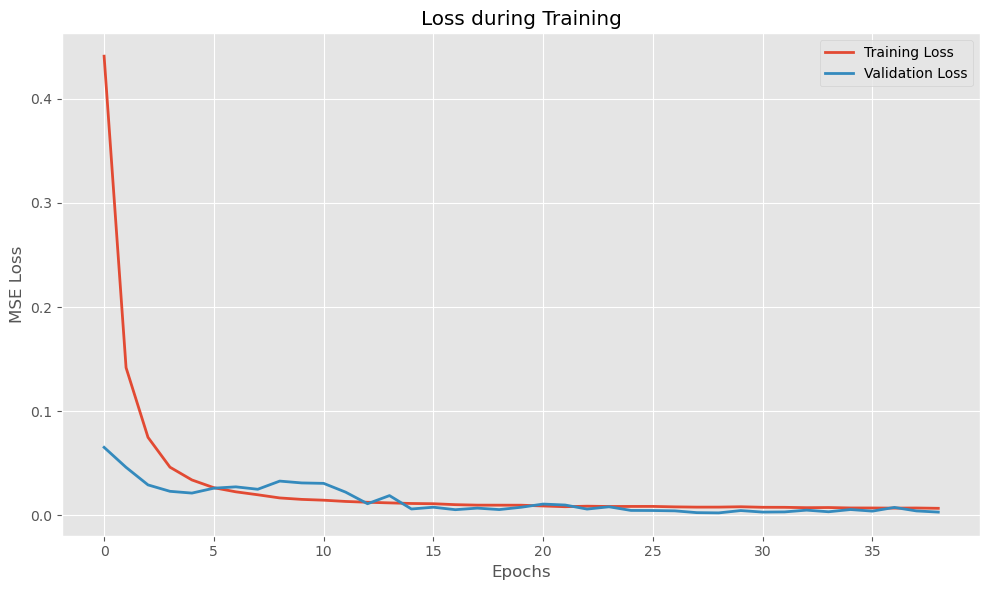

In [477]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Loss during Training')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

predictions on the test set, rescale back to original range, evaluate the model using RMSE and R² metrics

In [478]:
y_pred = model.predict(X_test)
min_val = scaler.data_min_[target_index]
max_val = scaler.data_max_[target_index]

y_pred_real = y_pred * (max_val - min_val) + min_val
y_test_real = y_test * (max_val - min_val) + min_val

y_test_flat = y_test_real.flatten()
y_pred_flat = y_pred_real.flatten()

rmse = np.sqrt(mean_squared_error(y_test_flat, y_pred_flat))
r2 = r2_score(y_test_flat, y_pred_flat)
print(f"RMSE (reale): {rmse:.2f}")
print(f"R² (reale): {r2:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
RMSE (reale): 312.82
R² (reale): 0.91


define a funcion that plots the comparison between actual and predicted value of a ceratain test sample, to see the differences

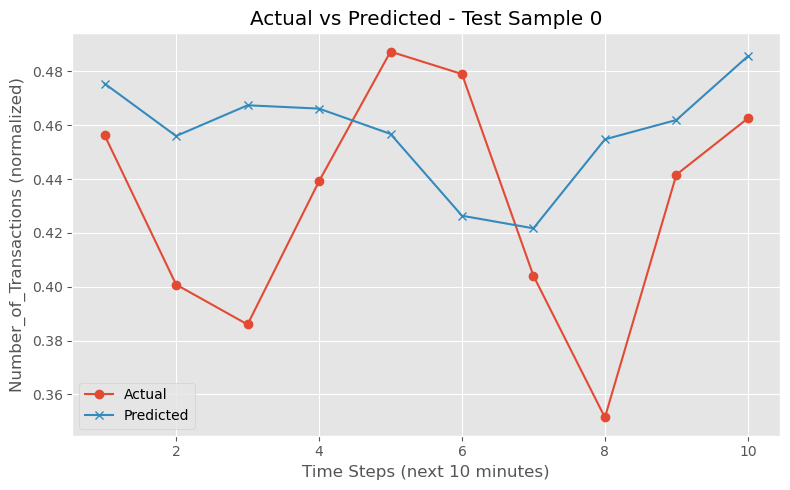

In [479]:
def plot_pred_vs_true(y_test, y_pred, index=0):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, 11), y_test[index], label='Actual', marker='o')
    plt.plot(range(1, 11), y_pred[index], label='Predicted', marker='x')
    plt.title(f'Actual vs Predicted - Test Sample {index}')
    plt.xlabel('Time Steps (next 10 minutes)')
    plt.ylabel('Number_of_Transactions (normalized)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_pred_vs_true(y_test, y_pred, index=0)

comparison of predicted vs actual transaction volumes over the next 10 minutes.  
plot of total sum and the average of the predicted vs real values for each sample, helping visualize how well the model captures short-term patterns


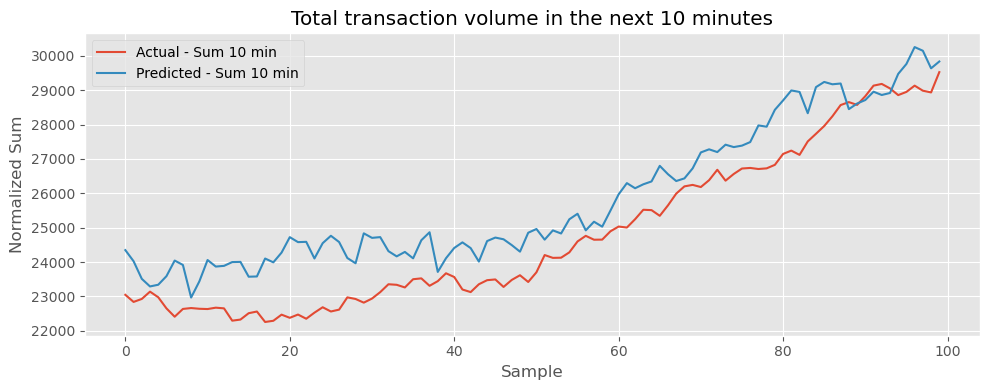

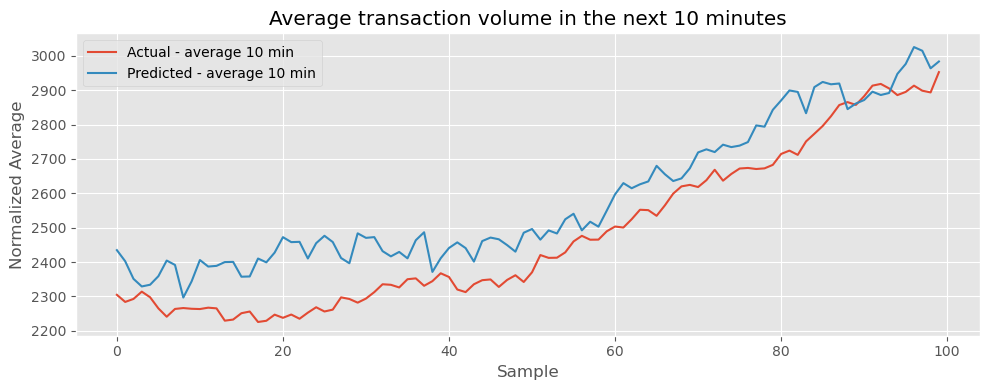

In [480]:
real_sum = np.sum(y_test_real, axis=1)
pred_sum = np.sum(y_pred_real, axis=1)

real_avg = np.mean(y_test_real, axis=1)
pred_avg = np.mean(y_pred_real, axis=1)

plt.figure(figsize=(10, 4))
plt.plot(real_sum[:100], label='Actual - Sum 10 min')
plt.plot(pred_sum[:100], label='Predicted - Sum 10 min')
plt.title('Total transaction volume in the next 10 minutes')
plt.xlabel('Sample')
plt.ylabel('Normalized Sum')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(real_avg[:100], label='Actual - average 10 min')
plt.plot(pred_avg[:100], label='Predicted - average 10 min')
plt.title('Average transaction volume in the next 10 minutes')
plt.xlabel('Sample')
plt.ylabel('Normalized Average')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


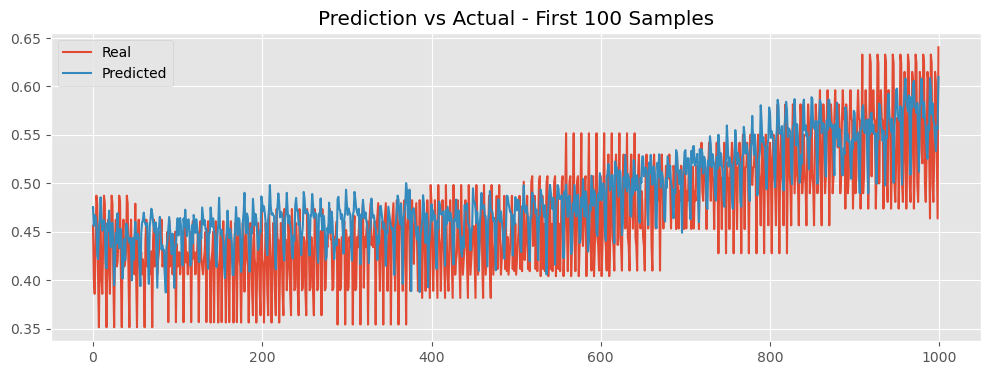

In [481]:
plt.figure(figsize=(12, 4))
plt.plot(y_test[0:100].flatten(), label="Real")
plt.plot(model.predict(X_test)[0:100].flatten(), label="Predicted")
plt.legend()
plt.title("Prediction vs Actual - First 100 Samples")
plt.show()

By plotting a histogram of the errors (actual − predicted), it reveals patterns such as bias, variance, and outliers in model performance. In our case the distribution of the error is normal. The model shows good accuracy and consistency, with the majority of predictions close to the actual values. 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


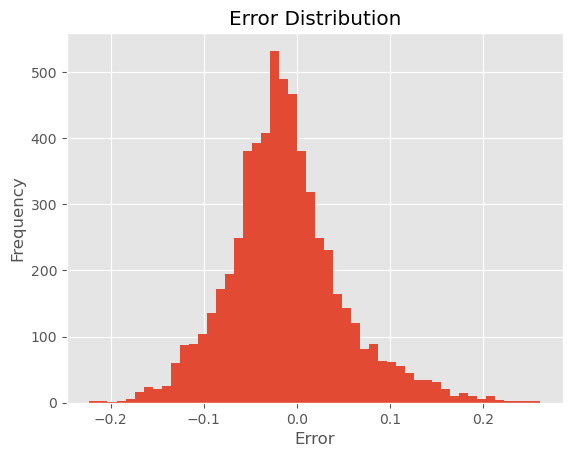

In [482]:
errors = y_test.flatten() - model.predict(X_test).flatten()

plt.hist(errors, bins=50)
plt.title("Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

cosine similarity measures how alike train and test sequences are; a mean of 0.70 indicates moderate similarity, highlighting potential overlap between the datasets

In [483]:
similarity = cosine_similarity(X_train.reshape(len(X_train), -1), X_test.reshape(len(X_test), -1))
print("Cosine similarity mean:", similarity.mean())

Cosine similarity mean: 0.7020860688914881


- we use as forecasting baseline a prophet forecasting model
- LSTM forecasting moodel seems to perform better than the baseline

20:17:45 - cmdstanpy - INFO - Chain [1] start processing
20:17:46 - cmdstanpy - INFO - Chain [1] done processing


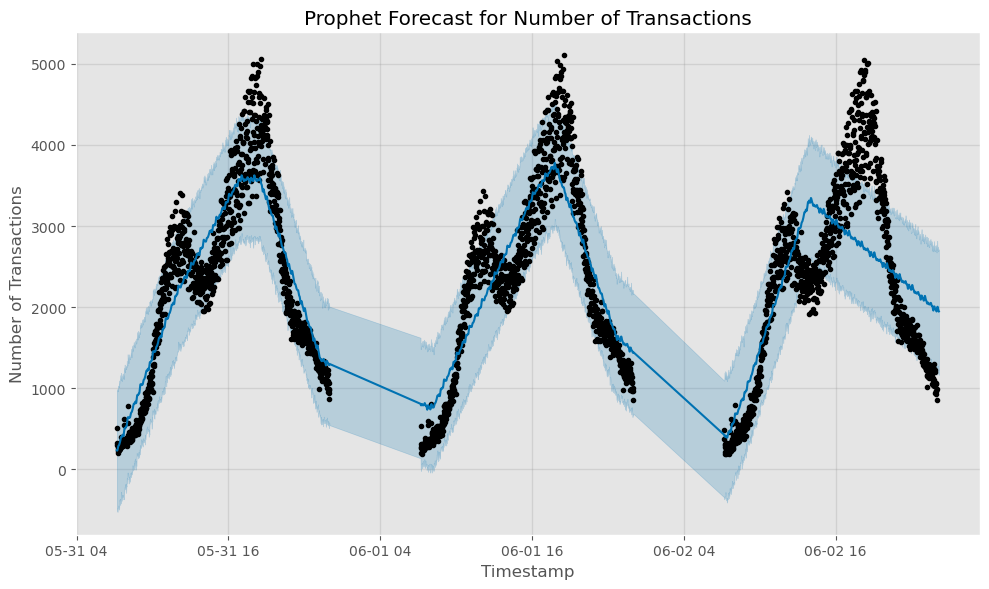

Mean Absolute Error (MAE): 467.83
Root Mean Squared Error (RMSE): 583.63
R² Score: 0.7459


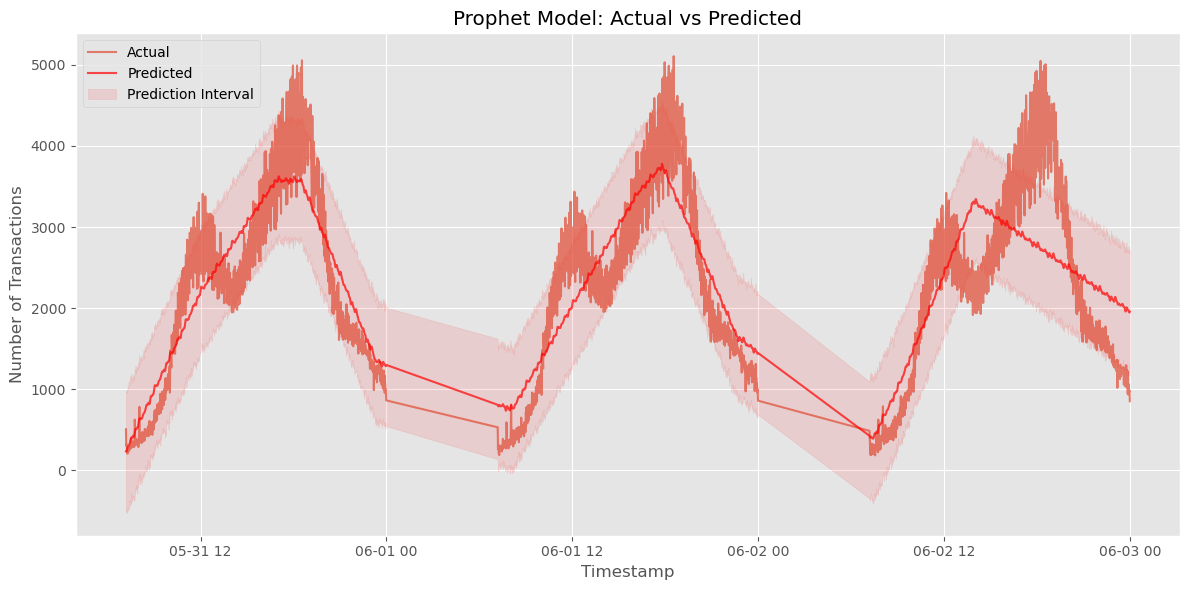

In [484]:
prophet_df = full_df[['Timestamp', 'Number_of_Transactions']].copy()
prophet_df = prophet_df.rename(columns={'Timestamp': 'ds', 'Number_of_Transactions': 'y'})

model_prophet = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    changepoint_prior_scale=0.05,
    seasonality_prior_scale=10
)

model_prophet.add_seasonality(name='hourly', period=1/24, fourier_order=8)
model_prophet.fit(prophet_df)
future = model_prophet.make_future_dataframe(periods=10, freq='T') 
forecast = model_prophet.predict(future)


fig = model_prophet.plot(forecast)
plt.title('Prophet Forecast for Number of Transactions')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.grid(True)
plt.tight_layout()
plt.show()


historical_forecast = forecast[forecast['ds'].isin(prophet_df['ds'])]
historical_truth = prophet_df.copy()

evaluation = pd.merge(historical_truth, historical_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

mae = mean_absolute_error(evaluation['y'], evaluation['yhat'])
rmse = np.sqrt(mean_squared_error(evaluation['y'], evaluation['yhat']))
r2 = r2_score(evaluation['y'], evaluation['yhat'])

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.4f}")


plt.figure(figsize=(12, 6))
plt.plot(evaluation['ds'], evaluation['y'], label='Actual', alpha=0.7)
plt.plot(evaluation['ds'], evaluation['yhat'], label='Predicted', color='red', alpha=0.7)
plt.fill_between(evaluation['ds'], evaluation['yhat_lower'], evaluation['yhat_upper'], 
                 color='red', alpha=0.1, label='Prediction Interval')
plt.title('Prophet Model: Actual vs Predicted')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Anomaly detection 

anomaly detection using the day 1 with outliers, that we know having anomalies to see if the model is able to correctly detect anomalies

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Calculated threshold: 0.0580
Number of anomalies detected: 49


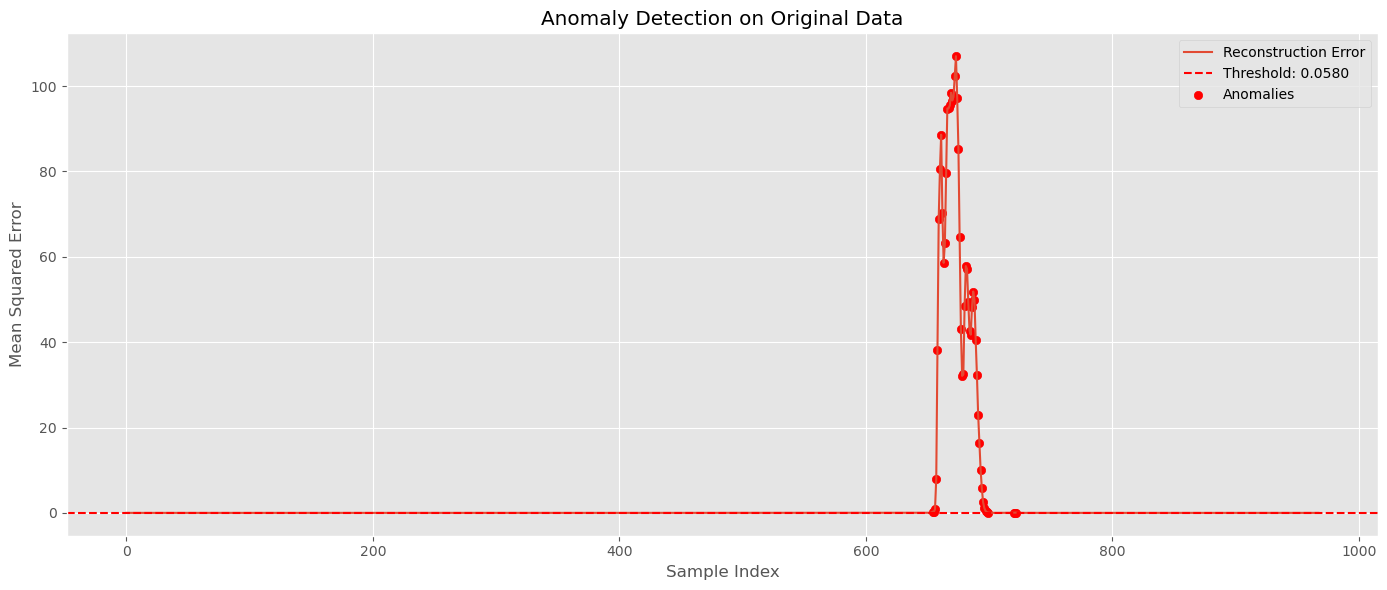

Top 10 detected anomalies:
             Timestamp  Actual     Predicted       Error
19 2024-05-31 19:05:05  3763.0  54067.753906  107.006987
18 2024-05-31 19:04:04  4326.0  50100.449219  102.424081
15 2024-05-31 19:01:03  2264.0  43966.656250   98.428755
17 2024-05-31 19:03:03  3637.0  50577.582031   97.454243
20 2024-05-31 19:06:05  3563.0  54383.828125   97.224598
16 2024-05-31 19:02:03  2411.0  45291.226562   96.619680
14 2024-05-31 19:00:03  2570.0  47127.402344   95.465141
13 2024-05-31 18:59:02  2704.0  45857.746094   94.807977
12 2024-05-31 18:58:02  2560.0  48150.792969   94.744023
7  2024-05-31 18:53:00  2641.0  48952.375000   88.602511


In [485]:
features = ['Number_of_Transactions', 'Time_Avg', 'Number_of_Wrong_Transactions', 'Number_of_Retries']
original_data= df[features]
original_df = df[['Timestamp'] + features].copy()
original_df['Day'] = 'Day0'  
processed_df = process_day(original_df) 
processed_df = processed_df.dropna()
processed_features = processed_df[selected_features]
scaled_features = scaler.transform(processed_features)

def create_sequences(data, input_window, output_window, target_index):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data[i:i + input_window])
        y.append(data[i + input_window:i + input_window + output_window, target_index])
    return np.array(X), np.array(y)


X_orig, y_orig = create_sequences(scaled_features, input_window, output_window, target_index)
predictions = model.predict(X_orig)
mse = np.mean(np.square(y_orig - predictions), axis=1)

# Calculate threshold based on 95th percentile of MSE
threshold = np.percentile(mse, 95)
print(f"Calculated threshold: {threshold:.4f}")

anomalies = np.where(mse > threshold)[0]
print(f"Number of anomalies detected: {len(anomalies)}")


plt.figure(figsize=(14, 6))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.scatter(anomalies, mse[anomalies], color='red', marker='o', label='Anomalies')
plt.title('Anomaly Detection on Original Data')
plt.xlabel('Sample Index')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


anomaly_indices = anomalies + input_window + output_window
anomaly_timestamps = processed_df.iloc[anomaly_indices]['Timestamp'].reset_index(drop=True)


min_val = scaler.data_min_[target_index]
max_val = scaler.data_max_[target_index]
y_orig_real = y_orig * (max_val - min_val) + min_val
pred_real = predictions * (max_val - min_val) + min_val


anomaly_data = pd.DataFrame({
    'Timestamp': anomaly_timestamps,
    'Actual': [y_orig_real[i, 0] for i in anomalies],
    'Predicted': [pred_real[i, 0] for i in anomalies],
    'Error': mse[anomalies]
})

print("Top 10 detected anomalies:")
print(anomaly_data.sort_values('Error', ascending=False).head(10))



- comparing the anomalies through residuals of LSTM and the isolation forest, we can see that there is an agreement of around 30%

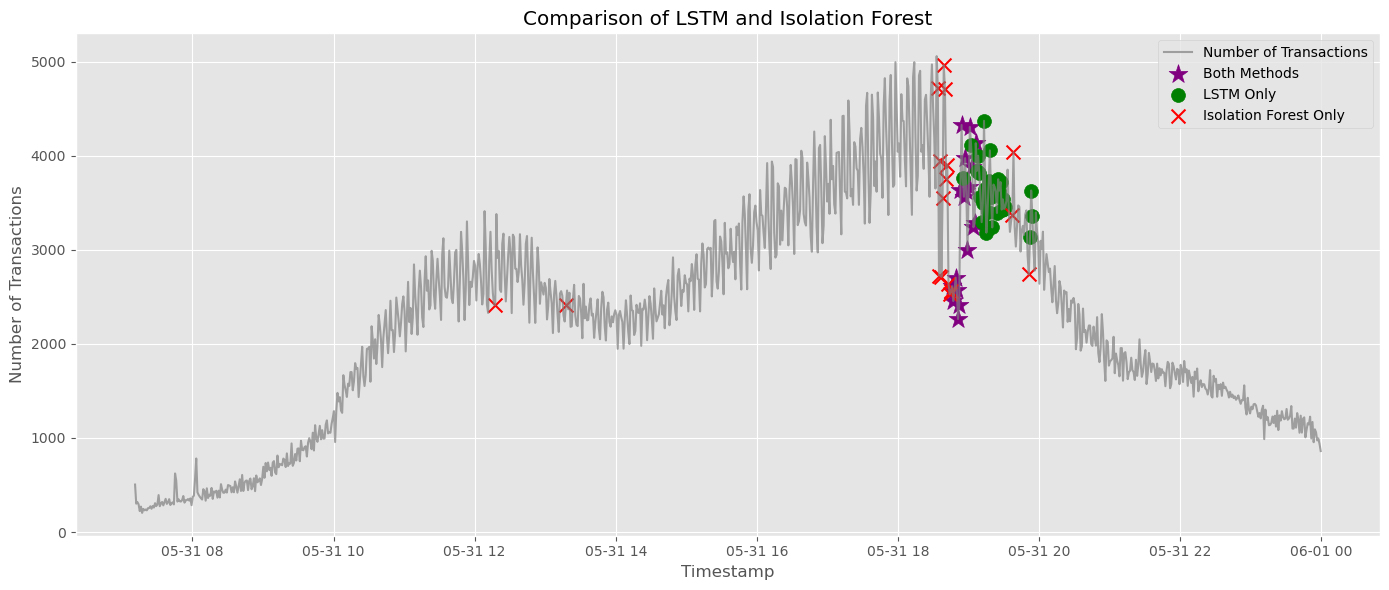

Total anomalies found by Isolation Forest: 36
Total anomalies found by LSTM: 49
Anomalies found by both methods: 19
Percentage of agreement between the two methods: 0.29


In [486]:

isolation_forest_anomalies = df[df['is_outlier']].index.tolist()
isolation_forest_timestamps = df[df['is_outlier']]['Timestamp']

lstm_anomaly_timestamps = anomaly_timestamps


comparison_df = pd.DataFrame({
    'Timestamp': processed_df['Timestamp'],
    'Number_of_Transactions': processed_df['Number_of_Transactions'],
    'LSTM_Anomaly': False,           
    'IsoForest_Anomaly': False
})

for ts in lstm_anomaly_timestamps:
    mask = comparison_df['Timestamp'] == ts
    comparison_df.loc[mask, 'LSTM_Anomaly'] = True

for ts in isolation_forest_timestamps:
    time_diffs = abs(comparison_df['Timestamp'] - ts)
    nearest_index = time_diffs.idxmin()
    comparison_df.loc[nearest_index, 'IsoForest_Anomaly'] = True

both_anomalies = (comparison_df['LSTM_Anomaly'] == True) & (comparison_df['IsoForest_Anomaly'] == True)
only_lstm = (comparison_df['LSTM_Anomaly'] == True) & (comparison_df['IsoForest_Anomaly'] == False)
only_isolation = (comparison_df['LSTM_Anomaly'] == False) & (comparison_df['IsoForest_Anomaly'] == True)

plt.figure(figsize=(14, 6))
plt.plot(comparison_df['Timestamp'], comparison_df['Number_of_Transactions'], label='Number of Transactions', color='gray', alpha=0.7)

plt.scatter(comparison_df.loc[both_anomalies, 'Timestamp'], comparison_df.loc[both_anomalies, 'Number_of_Transactions'],
            color='purple', label='Both Methods', marker='*', s=200)

plt.scatter(comparison_df.loc[only_lstm, 'Timestamp'], comparison_df.loc[only_lstm, 'Number_of_Transactions'],
            color='green', label='LSTM Only', marker='o', s=100)

plt.scatter(comparison_df.loc[only_isolation, 'Timestamp'], comparison_df.loc[only_isolation, 'Number_of_Transactions'],
            color='red', label='Isolation Forest Only', marker='x', s=100)

plt.title('Comparison of LSTM and Isolation Forest')
plt.xlabel('Timestamp')
plt.ylabel('Number of Transactions')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Total anomalies found by Isolation Forest:", len(isolation_forest_timestamps))
print("Total anomalies found by LSTM:", len(lstm_anomaly_timestamps))
print("Anomalies found by both methods:", both_anomalies.sum())

totale_anomalie_rilevate = (comparison_df['LSTM_Anomaly'] | comparison_df['IsoForest_Anomaly']).sum()
agreement_rate = both_anomalies.sum() / max(1, totale_anomalie_rilevate)
print(f"Percentage of agreement between the two methods: {agreement_rate:.2f}")


### Multivariate LSTM forecasting model

we believe that we could improve the corrispondance bewteen the anomaly detected through LSTM residuals and the ones detected by the isolation forest (our baseline, that has a multivariate approach), through the building of a multivariate LSTM, considering as target `Number_of_Transactions`,`Time_Avg`,`Number_of_Retries`, `Number_of_Wrong_Transactions`

In [487]:
target_columns = [
    'Number_of_Transactions',
    'Time_Avg',
    'Number_of_Retries',
    'Number_of_Wrong_Transactions'
]

def create_seq2seq_data(data, target_columns, input_window, output_window):
    X, y = [], []
    for i in range(len(data) - input_window - output_window):
        X.append(data.iloc[i:i+input_window].values)
        y.append(data.iloc[i+input_window:i+input_window+output_window][target_columns].values)
    return np.array(X), np.array(y)


input_window = 30  # past 30 minutes
output_window = 10  # predict next 10 minutes

df_model = full_df.drop(columns=["Timestamp"])

X_seq2seq, y_seq2seq = create_seq2seq_data(df_model, target_columns, input_window, output_window)

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_seq2seq, y_seq2seq, test_size=0.2, shuffle=False)

n_features = X_seq2seq.shape[2]
scaler = MinMaxScaler()
X_train_2d = X_train2.reshape(-1, n_features)
X_test_2d = X_test2.reshape(-1, n_features)

X_train_scaled = scaler.fit_transform(X_train_2d)
X_test_scaled = scaler.transform(X_test_2d)

X_train = X_train_scaled.reshape(X_train2.shape)
X_test = X_test_scaled.reshape(X_test2.shape)

target_scaler = MinMaxScaler()
y_train = target_scaler.fit_transform(y_train2.reshape(-1, len(target_columns))).reshape(y_train2.shape)
y_test = target_scaler.transform(y_test2.reshape(-1, len(target_columns))).reshape(y_test2.shape)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

input_timesteps = input_window
output_timesteps = output_window
n_outputs = len(target_columns)

In [488]:
encoder_inputs = Input(shape=(input_timesteps, n_features))
encoder_lstm = LSTM(64, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

decoder_inputs = RepeatVector(output_timesteps)(encoder_outputs)
decoder_lstm = LSTM(64, return_sequences=True)
decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)

decoder_dense = TimeDistributed(Dense(n_outputs))
outputs = decoder_dense(decoder_outputs)

model = Model(encoder_inputs, outputs)
model.compile(optimizer='adam', loss='mse')
model.summary()

early_stop = EarlyStopping(
    monitor='val_loss', 
    patience=5,      
    restore_best_weights=True, 
    verbose=1
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[early_stop],  
    verbose=1
)

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 30, 73)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_25 (LSTM)      │ [(None, 64),      │     35,328 │ input_layer_17[0… │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_vector_8     │ (None, 10, 64)    │          0 │ lstm_25[0][0]     │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_26 (LSTM)      │ (None, 10, 64)    │     33,024 │ repeat_vector_8[… │
│                     │                   │            │ lstm_25[0][1],    │
│                     │                   │            │ lstm_25[0][2]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_8  │ (None, 10, 4)     │        260 │ lstm_26[0][0]     │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 68,612 (268.02 KB)

 Trainable params: 68,612 (268.02 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0236 - val_loss: 0.0070
Epoch 2/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0055 - val_loss: 0.0067
Epoch 3/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0054 - val_loss: 0.0067
Epoch 4/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0053 - val_loss: 0.0066
Epoch 5/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 6/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0052 - val_loss: 0.0065
Epoch 7/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0052 - val_loss: 0.0064
Epoch 8/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 9/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 10/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0051 - val_loss: 0.0064
Epoch 11/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0050 - val_loss: 0.0063
Epoch 12/30
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0050 - val_

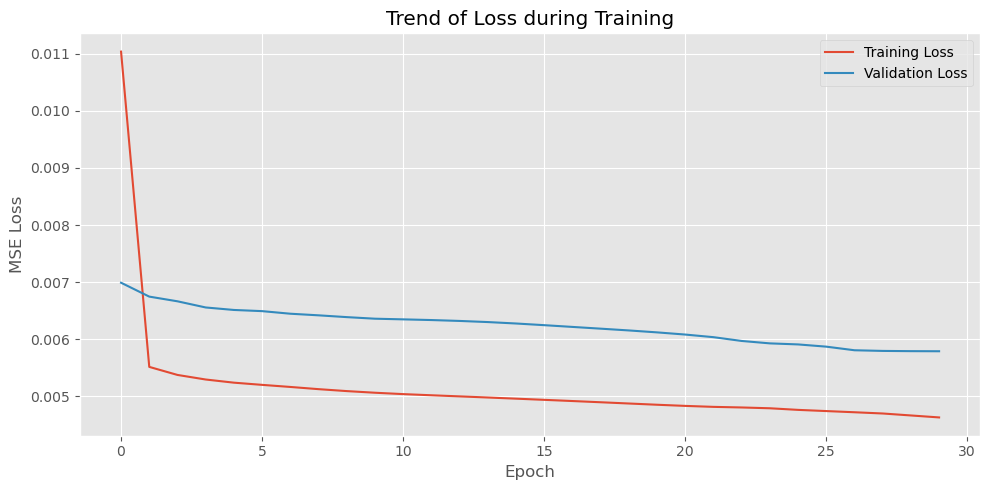

In [489]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Trend of Loss during Training')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [490]:
y_pred_scaled = model.predict(X_test)

y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 4)).reshape(y_pred_scaled.shape)
y_true = target_scaler.inverse_transform(y_test.reshape(-1, 4)).reshape(y_test.shape)

y_pred_flat = y_pred.reshape(-1, len(target_columns))
y_true_flat = y_true.reshape(-1, len(target_columns))

print("Forecast Evaluation Metrics:\n")
for i, col in enumerate(target_columns):
    mse = mean_squared_error(y_true_flat[:, i], y_pred_flat[:, i])
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true_flat[:, i], y_pred_flat[:, i])
    r2 = r2_score(y_true_flat[:, i], y_pred_flat[:, i])
    print(f"{col}:")
    print(f"  RMSE = {rmse:.4f}")
    print(f"  MAE  = {mae:.4f}")
    print(f"  R²   = {r2:.4f}\n")

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Forecast Evaluation Metrics:

Number_of_Transactions:
  RMSE = 266.5602
  MAE  = 196.5584
  R²   = 0.9350

Time_Avg:
  RMSE = 43.0186
  MAE  = 19.0689
  R²   = 0.2967

Number_of_Retries:
  RMSE = 25.9351
  MAE  = 8.8669
  R²   = 0.2489

Number_of_Wrong_Transactions:
  RMSE = 36.0917
  MAE  = 29.5842
  R²   = 0.1319



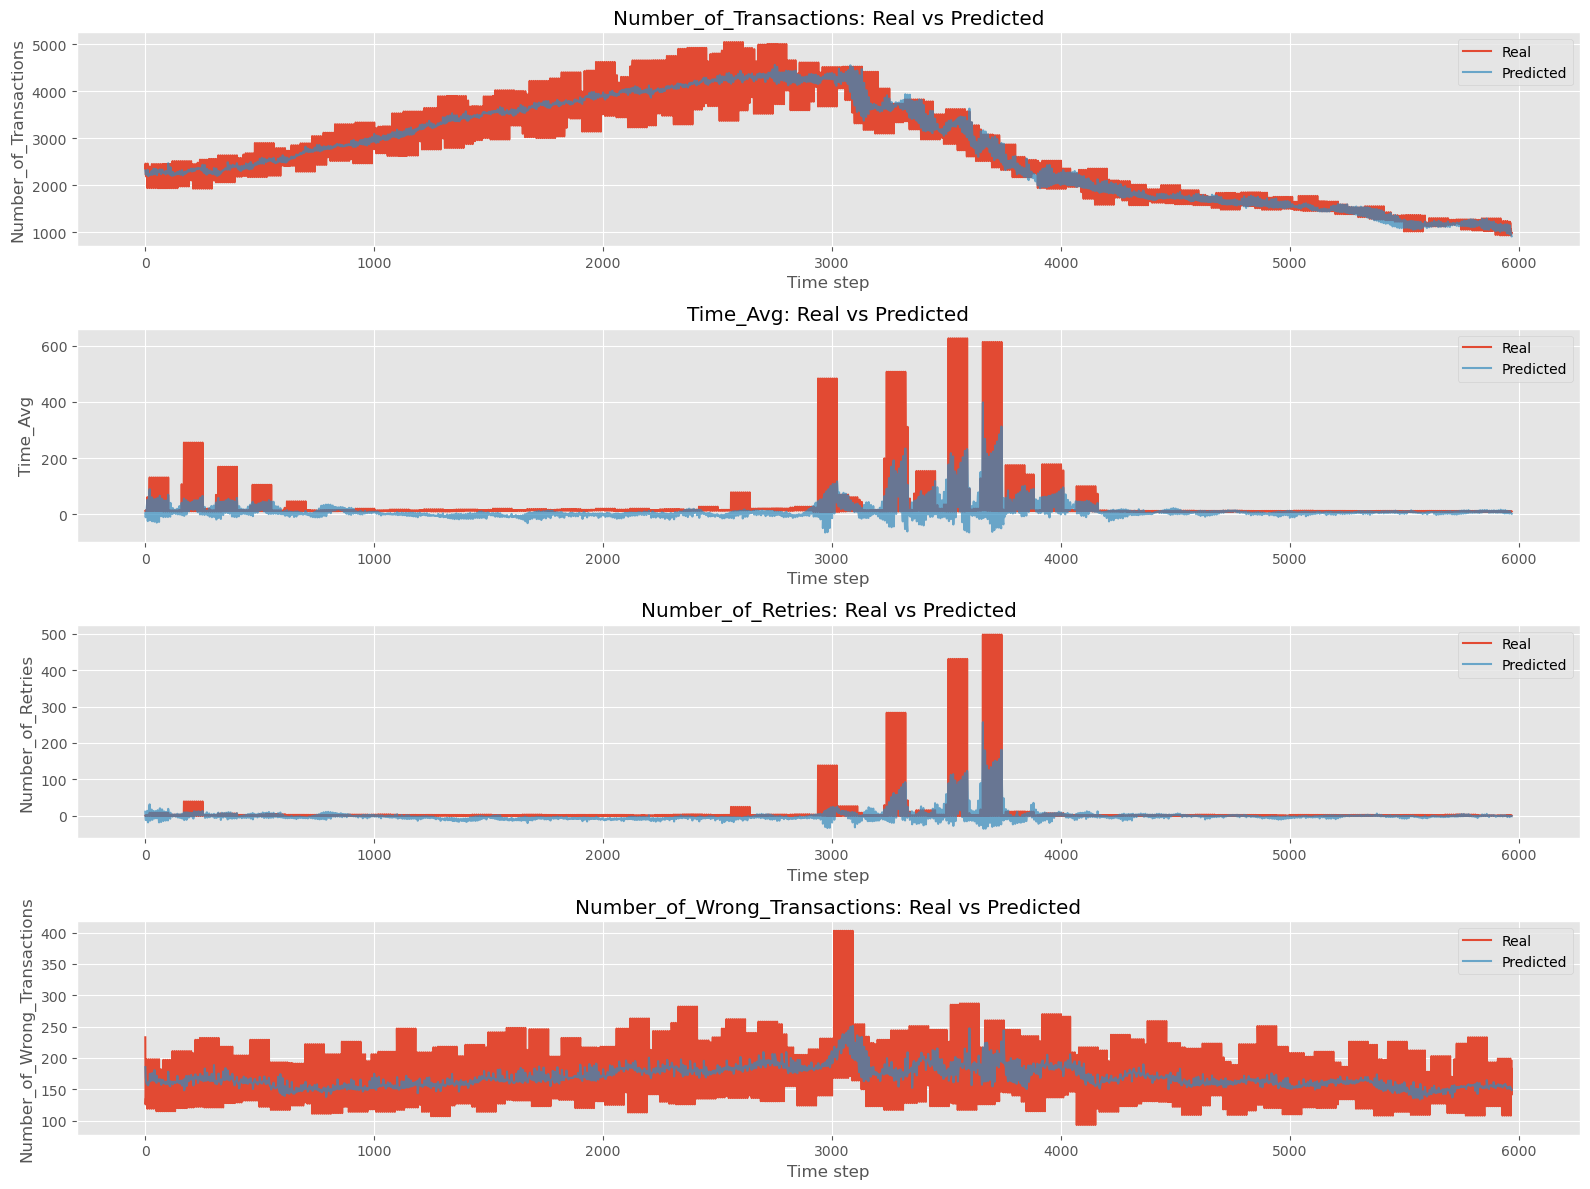

In [493]:
n_outputs = y_true.shape[2]
output_window = y_true.shape[1]
target_names = ['Number_of_Transactions', 'Time_Avg', 'Number_of_Retries', 'Number_of_Wrong_Transactions']

y_true_flat = y_true.reshape(-1, n_outputs)
y_pred_flat = y_pred.reshape(-1, n_outputs)


time_axis = range(len(y_true_flat))


plt.figure(figsize=(16, 12))

for i in range(n_outputs):
    plt.subplot(n_outputs, 1, i + 1)
    plt.plot(time_axis, y_true_flat[:, i], label='Real')
    plt.plot(time_axis, y_pred_flat[:, i], label='Predicted', alpha=0.7)
    plt.title(f"{target_names[i]}: Real vs Predicted")
    plt.ylabel(target_names[i])
    plt.xlabel("Time step")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

as above for the univariate model, we use the LSTM for anomaly detection, we try to make predictions based on the data of the original day and we see if it detects the same anomalies identified by the isolation forest 

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


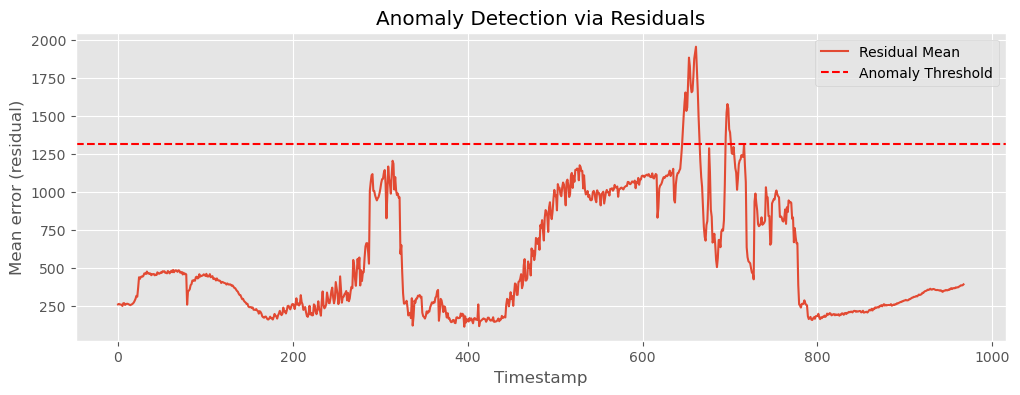

,Timestamp,Residual,Anomaly
0,2024-05-31 07:51:13,259.067728,False
1,2024-05-31 07:52:14,262.423210,False
2,2024-05-31 07:53:14,258.796693,False
3,2024-05-31 07:54:14,258.270929,False
4,2024-05-31 07:55:14,256.780383,False


In [494]:
df_proc = df.copy()
df_proc = process_day(df_proc)
df_proc.dropna(inplace=True)
df_proc = df_proc.drop(columns=['Time_Min', 'Time_Max', 'outlier', 'is_outlier'])


df_proc_input = df_proc.drop(columns=["Timestamp"])
X_orig_seq, y_orig_seq = create_seq2seq_data(     #function defined above 
    df_proc_input, target_columns, input_window, output_window
)

X_orig_scaled = scaler.transform(X_orig_seq.reshape(-1, n_features)).reshape(X_orig_seq.shape)  #use the same scaler as before
y_orig_scaled = target_scaler.transform(y_orig_seq.reshape(-1, len(target_columns))).reshape(y_orig_seq.shape)

y_pred_scaled = model.predict(X_orig_scaled)
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1, 4)).reshape(y_pred_scaled.shape)
y_true = target_scaler.inverse_transform(y_orig_scaled.reshape(-1, 4)).reshape(y_orig_scaled.shape)

residuals = np.abs(y_true - y_pred)  
residuals_mean = residuals.mean(axis=(1, 2))  #average residuals for the 4 targets per window

threshold = residuals_mean.mean() + 2 * residuals_mean.std()
anomalies = residuals_mean > threshold

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(residuals_mean, label='Residual Mean')
plt.axhline(threshold, color='red', linestyle='--', label='Anomaly Threshold')
plt.title("Anomaly Detection via Residuals")
plt.xlabel("Timestamp")
plt.ylabel("Mean error (residual)")
plt.legend()
plt.show()


timestamps = df_proc['Timestamp'].iloc[input_window + output_window : input_window + output_window + len(anomalies)] #associates timestamps to anomalies
anomaly_df = pd.DataFrame({
    'Timestamp': timestamps.values,
    'Residual': residuals_mean[:len(anomalies)],
    'Anomaly': anomalies[:len(anomalies)]
})

anomaly_df.head()

we filter the examples of anomalies we found. Then we see how many anomalous windows were found

In [495]:
anomalous_rows = anomaly_df[anomaly_df['Anomaly'] == True]

print("Examples of detected anomalies:")
print(anomalous_rows.head())


num_anomalies = anomalous_rows.shape[0]
total_windows = len(anomaly_df)
percentage = (num_anomalies / total_windows) * 100

print(f"\nNumber of anomalous windows: {num_anomalies}")
print(f"Total number of windows analyzed: {total_windows}")
print(f"Anomaly percentage: {percentage:.2f}%")

Examples of detected anomalies:
              Timestamp     Residual  Anomaly
646 2024-05-31 18:37:50  1409.677957     True
647 2024-05-31 18:38:51  1506.217853     True
648 2024-05-31 18:39:51  1592.723985     True
649 2024-05-31 18:40:51  1654.460349     True
650 2024-05-31 18:41:52  1533.129597     True

Number of anomalous windows: 27
Total number of windows analyzed: 968
Anomaly percentage: 2.79%


we isolate the timestamps where your model flagged an anomaly
then matched the model detected anomalies the outliers identified by the isolation forest within a ±5 minute window (since the LSTM works with sequences) and created a cross-tabulation to evaluate overlap between LSTM-based detection and Isolation Forest labels.

In [496]:
detected_anomalies = anomaly_df[anomaly_df['Anomaly'] == True]['Timestamp']
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
detected_anomalies = pd.to_datetime(detected_anomalies)


df['Detected_By_Model'] = False
for t in detected_anomalies:
    mask = (df['Timestamp'] >= t - timedelta(minutes=5)) & (df['Timestamp'] <= t + timedelta(minutes=5))
    df.loc[mask, 'Detected_By_Model'] = True

pd.crosstab(df['is_outlier'], df['Detected_By_Model'], rownames=['Isolation Forest Outlier'], colnames=['Detected by LSTM'])

Detected by LSTM,False,True
Isolation Forest Outlier,,
False,967,15
True,7,29


recall = True positive / Actual positive = 29/(7+29)

In [497]:
matched = df[(df['is_outlier'] == 1) & (df['Detected_By_Model'] == True)]
total_true_outliers = df['is_outlier'].sum()
recall = len(matched) / total_true_outliers * 100

print(f"Recall: {recall:.2f}%")

Recall: 80.56%


In [498]:
#observations detected by both methods
matched_observations = df[(df['is_outlier'] == 1) & (df['Detected_By_Model'] == True)]

print("Observations detected by both Isolation Forest and LSTM model:")
matched_observations.tail(10)

Observations detected by both Isolation Forest and LSTM model:


,Timestamp,Number_of_Transactions,Time_Min,Time_Max,Time_Avg,Number_of_Retries,Number_of_Wrong_Transactions,outlier,is_outlier,Detected_By_Model
711,2024-05-31 18:53:00,3637,0,40480,902.315250,1162,219,-1,True,True
712,2024-05-31 18:54:00,4326,0,5350,541.213750,230,185,-1,True,True
714,2024-05-31 18:56:01,3563,1,4762,105.871506,5,410,-1,True,True
715,2024-05-31 18:57:01,3973,2,1352,57.112330,1,448,-1,True,True
716,2024-05-31 18:58:02,3621,0,8855,766.188300,1270,138,-1,True,True
717,2024-05-31 18:59:02,2993,0,20560,906.975000,3196,218,-1,True,True
718,2024-05-31 19:00:03,3666,0,11086,973.061160,2429,245,-1,True,True
719,2024-05-31 19:01:03,4305,1,9896,125.240910,150,389,-1,True,True
755,2024-05-31 19:37:08,3373,1,6906,594.361000,688,247,-1,True,True
756,2024-05-31 19:38:08,4037,0,12031,713.231260,1243,176,-1,True,True


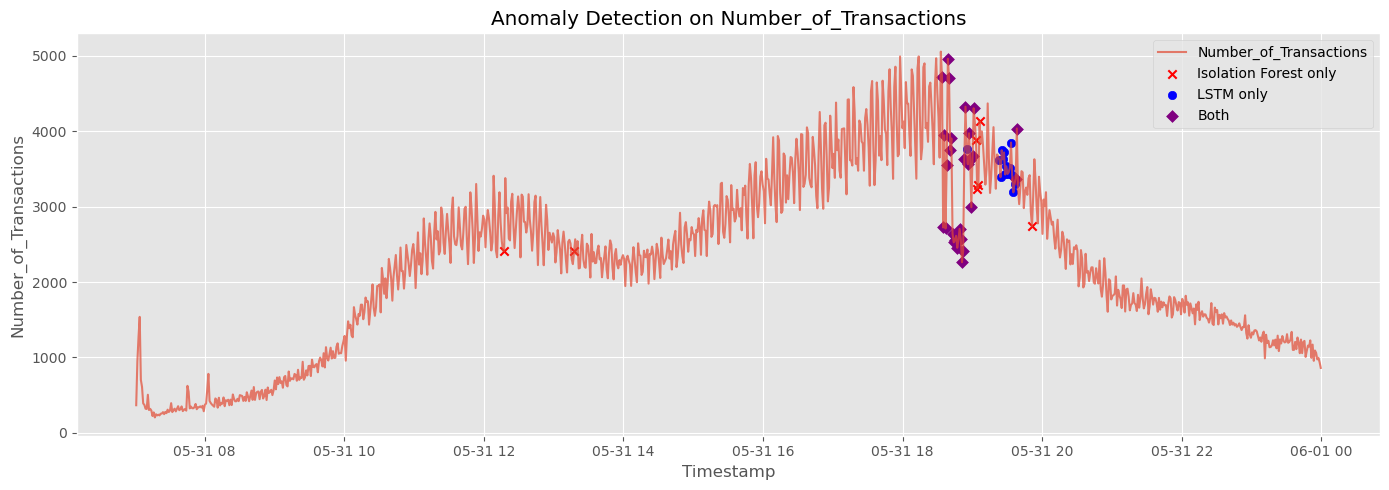

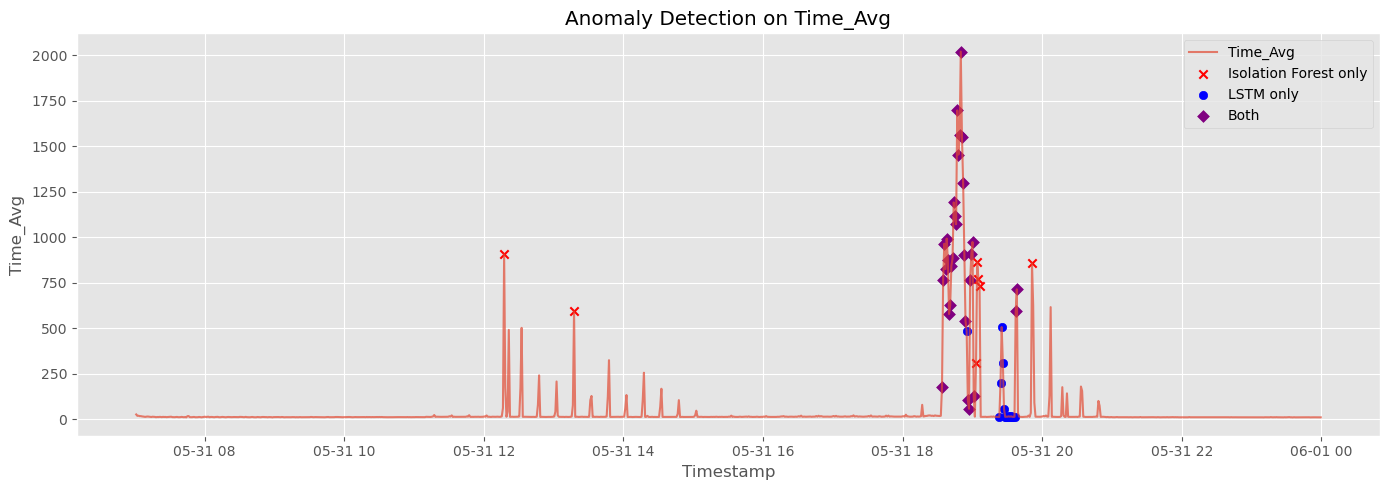

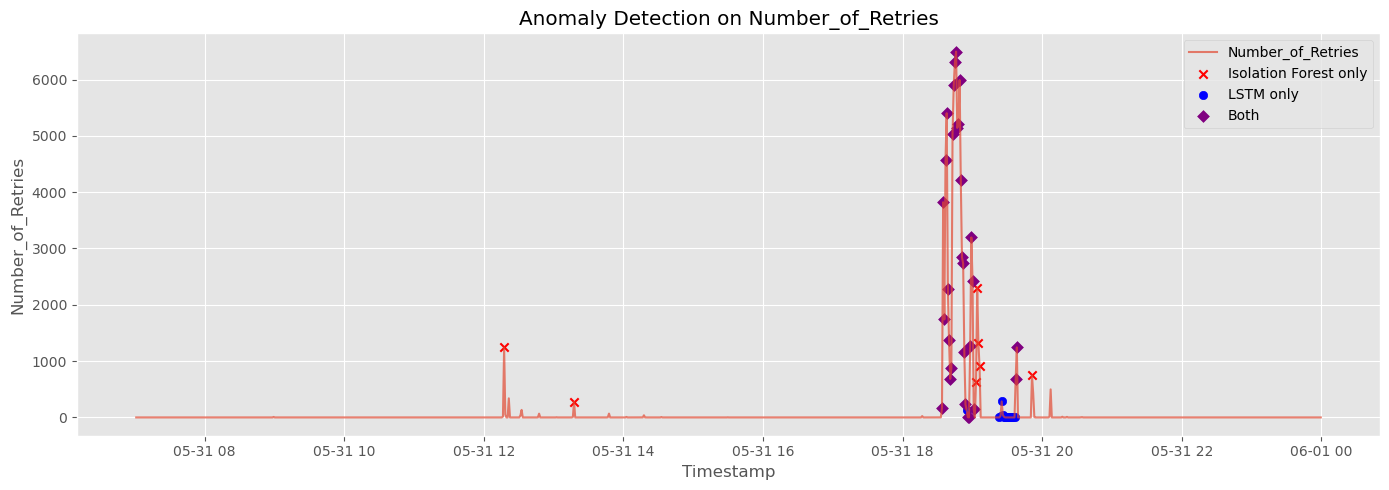

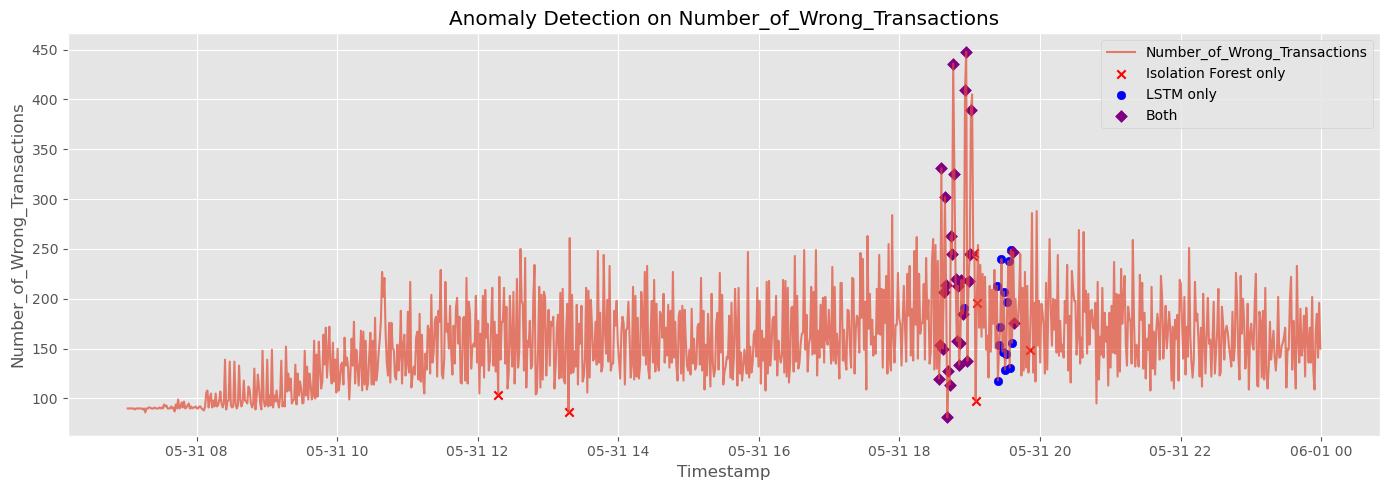

In [499]:
df_sorted = df.sort_values("Timestamp")

target_columns = [
    'Number_of_Transactions',
    'Time_Avg',
    'Number_of_Retries',
    'Number_of_Wrong_Transactions'
]

only_iforest = df_sorted[(df_sorted['is_outlier'] == 1) & (df_sorted['Detected_By_Model'] == False)]
only_lstm = df_sorted[(df_sorted['is_outlier'] == 0) & (df_sorted['Detected_By_Model'] == True)]
both = df_sorted[(df_sorted['is_outlier'] == 1) & (df_sorted['Detected_By_Model'] == True)]

for col in target_columns:
    plt.figure(figsize=(14, 5))
    plt.plot(df_sorted['Timestamp'], df_sorted[col], label=col, alpha=0.7)

    plt.scatter(only_iforest['Timestamp'], only_iforest[col], color='red', label='Isolation Forest only', marker='x')
    plt.scatter(only_lstm['Timestamp'], only_lstm[col], color='blue', label='LSTM only', marker='o')
    plt.scatter(both['Timestamp'], both[col], color='purple', label='Both', marker='D')

    plt.title(f"Anomaly Detection on {col}")
    plt.xlabel("Timestamp")
    plt.ylabel(col)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()